# Análise de Dados da Estação Tapirus

Este notebook contém análises dos dados meteorológicos da estação Tapirus, com foco em:
- Visão semanal dos dados
- Comparação entre dois anos (2023-2024 vs 2024-2025)
- Análise de períodos de chuva e sua relação com a colheita
- Insights para justificar arrendamento para cana em terras atuais de grãos e mandioca

## 1. Importação de Bibliotecas

In [51]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import calendar
import warnings
warnings.filterwarnings('ignore')

# Configurações para melhorar a visualização dos gráficos
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## 2. Definição dos Caminhos dos Arquivos

In [52]:
# Definindo o caminho para os arquivos de dados
data_path = 'Dados/'
file_2023_2024 = 'Regional Tapirus out23-mar24.xlsx'
file_2024_2025 = 'Regional Tapirus out24-mar25.xlsx'

# Verificando se os arquivos existem
print(f"Arquivo 2023-2024 existe: {os.path.exists(os.path.join(data_path, file_2023_2024))}")
print(f"Arquivo 2024-2025 existe: {os.path.exists(os.path.join(data_path, file_2024_2025))}")

Arquivo 2023-2024 existe: True
Arquivo 2024-2025 existe: True


## 3. Carregamento e Preparação dos Dados

### 3.1 Função para Carregar Dados

In [53]:
# Função para carregar e preparar os dados
def carregar_dados(arquivo, periodo):
    try:
        # Carregando o arquivo Excel
        df = pd.read_excel(os.path.join(data_path, arquivo))
        
        # Exibindo as primeiras linhas para entender a estrutura
        print(f"\nPrimeiras linhas do arquivo {periodo}:")
        print(df.head())
        
        # Verificando as colunas disponíveis
        print(f"\nColunas disponíveis no arquivo {periodo}:")
        print(df.columns.tolist())
        
        # Verificando tipos de dados
        print(f"\nTipos de dados no arquivo {periodo}:")
        print(df.dtypes)
        
        # Verificando valores nulos
        print(f"\nValores nulos no arquivo {periodo}:")
        print(df.isnull().sum())
        
        # Adicionando uma coluna de período para identificação
        df['Periodo'] = periodo
        
        return df
    
    except Exception as e:
        print(f"Erro ao carregar o arquivo {arquivo}: {e}")
        return None

### 3.2 Carregamento dos Dados

In [54]:
# Carregando os dados dos dois períodos
df_2023_2024 = carregar_dados(file_2023_2024, "2023-2024")
df_2024_2025 = carregar_dados(file_2024_2025, "2024-2025")


Primeiras linhas do arquivo 2023-2024:
     id                    nome       lat       lon início do periodo [GMT-3]  \
0  5806  Regional Tapirus | NRD -22.50305 -51.31979          01/10/2023 00:00   
1  5806  Regional Tapirus | NRD -22.50305 -51.31979          02/10/2023 00:00   
2  5806  Regional Tapirus | NRD -22.50305 -51.31979          03/10/2023 00:00   
3  5806  Regional Tapirus | NRD -22.50305 -51.31979          04/10/2023 00:00   
4  5806  Regional Tapirus | NRD -22.50305 -51.31979          05/10/2023 00:00   

  final do periodo [GMT-3] Pic Inativa  precipitação [mm]  \
0         02/10/2023 00:00         Não                0.0   
1         03/10/2023 00:00         Não                0.0   
2         04/10/2023 00:00         Não                0.0   
3         05/10/2023 00:00         Não                0.0   
4         06/10/2023 00:00         Não                4.0   

   temperatura mínima [ºC]  temperatura média [ºC]  temperatura máxima [ºC]  \
0                     20.5 

### 3.3 Padronização das Colunas

In [55]:
# Função para padronizar os nomes das colunas
def padronizar_colunas(df):
    # Mapeamento de nomes de colunas (ajustando para os nomes reais encontrados nos arquivos)
    mapeamento = {
        'início do periodo [GMT-3]': 'Data_Inicial',
        'final do periodo [GMT-3]': 'Data_Final',
        'Pic Inativa': 'Pic_Inativa',
        'precipitação [mm]': 'Precipitacao',
        'temperatura máxima [ºC]': 'Temp_Max',
        'temperatura mínima [ºC]': 'Temp_Min',
        'temperatura média [ºC]': 'Temp_Media',
        'umidade mínima [%]': 'Umidade_Min',
        'umidade média [%]': 'Umidade_Media',
        'umidade máxima [%]': 'Umidade_Max',
        'luminosidade [Wh/m²]': 'Luminosidade',
        'velocidade média do vento [km/h]': 'Velocidade_Vento',
        'Rajada de vento maxima [km/h]': 'Rajada_Vento'
    }
        
    # Renomeando colunas que existem no DataFrame
    colunas_para_renomear = {col: novo_nome for col, novo_nome in mapeamento.items() if col in df.columns}
    if colunas_para_renomear:
        df = df.rename(columns=colunas_para_renomear)
        
    return df

### 3.4 Adição de Informações Temporais

In [56]:
# Função para adicionar informações de semana, mês e estação
def adicionar_info_temporal(df):
    # Garantindo que a coluna de data é do tipo datetime
    if 'Data_Inicial' in df.columns:
        df['Data'] = pd.to_datetime(df['Data_Inicial'], format='%d/%m/%Y %H:%M', dayfirst=True)
        
        # Adicionando número da semana do ano
        df['Semana_Ano'] = df['Data'].dt.isocalendar().week
        
        # Adicionando mês e nome do mês
        df['Mes'] = df['Data'].dt.month
        df['Nome_Mes'] = df['Data'].dt.month_name()
        
        # Adicionando ano
        df['Ano'] = df['Data'].dt.year
        
        # Adicionando semana sequencial (para facilitar a comparação entre períodos)
        data_inicial = df['Data'].min()
        df['Semana_Sequencial'] = ((df['Data'] - data_inicial).dt.days // 7) + 1
        
        # Adicionando estação do ano (considerando hemisfério sul)
        # Verão: Dezembro a Fevereiro
        # Outono: Março a Maio
        # Inverno: Junho a Agosto
        # Primavera: Setembro a Novembro
        def determinar_estacao(mes):
            if mes in [12, 1, 2]:
                return "Verão"
            elif mes in [3, 4, 5]:
                return "Outono"
            elif mes in [6, 7, 8]:
                return "Inverno"
            else:  # mes in [9, 10, 11]
                return "Primavera"
        
        df['Estacao'] = df['Mes'].apply(determinar_estacao)
    
    return df

### 3.5 Estatísticas Descritivas dos DataFrames

In [57]:
# Estatísticas descritivas do DataFrame 2023-2024
print("\nEstatísticas descritivas do DataFrame 2023-2024:")
print(df_2023_2024.describe())

# Estatísticas descritivas do DataFrame 2024-2025
print("\nEstatísticas descritivas do DataFrame 2024-2025:")
print(df_2024_2025.describe())

# Verificando valores únicos em colunas categóricas para cada DataFrame
print("\nValores únicos em colunas categóricas (2023-2024):")
for coluna in ['Estacao', 'Nome_Mes']:
    if coluna in df_2023_2024.columns:
        print(f"{coluna}: {df_2023_2024[coluna].unique().tolist()}")

print("\nValores únicos em colunas categóricas (2024-2025):")
for coluna in ['Estacao', 'Nome_Mes']:
    if coluna in df_2024_2025.columns:
        print(f"{coluna}: {df_2024_2025[coluna].unique().tolist()}")


Estatísticas descritivas do DataFrame 2023-2024:
           id           lat           lon  precipitação [mm]  \
count   183.0  1.830000e+02  1.830000e+02         183.000000   
mean   5806.0 -2.250305e+01 -5.131979e+01           3.622951   
std       0.0  3.562461e-15  1.424984e-14          11.751311   
min    5806.0 -2.250305e+01 -5.131979e+01           0.000000   
25%    5806.0 -2.250305e+01 -5.131979e+01           0.000000   
50%    5806.0 -2.250305e+01 -5.131979e+01           0.000000   
75%    5806.0 -2.250305e+01 -5.131979e+01           1.800000   
max    5806.0 -2.250305e+01 -5.131979e+01         133.800000   

       temperatura mínima [ºC]  temperatura média [ºC]  \
count               183.000000              183.000000   
mean                 21.054098               26.348087   
std                   2.262006                2.498787   
min                  13.500000               19.600000   
25%                  19.700000               24.900000   
50%                  21.5

## 4. Análise Semanal dos Dados

### 4.1 Função para Análise Semanal Comparativa

In [58]:
# Função para análise semanal comparativa de diferentes variáveis
def analise_semanal_comparativa(df1, df2, coluna_valor, titulo, ylabel):
    # Agrupando por semana para cada DataFrame
    df1_semanal = df1.groupby('Semana_Sequencial')[coluna_valor].agg(['mean', 'min', 'max', 'sum']).reset_index()
    df2_semanal = df2.groupby('Semana_Sequencial')[coluna_valor].agg(['mean', 'min', 'max', 'sum']).reset_index()
    
    # Criando o gráfico
    plt.figure(figsize=(16, 8))
    
    # Plotando dados do primeiro período (2023-2024)
    plt.plot(df1_semanal['Semana_Sequencial'], df1_semanal['mean'], 
             label="2023-2024 (Média)", linewidth=2, marker='s')
    plt.fill_between(df1_semanal['Semana_Sequencial'], 
                    df1_semanal['min'], 
                    df1_semanal['max'], 
                    alpha=0.2, color='blue')
    
    # Plotando dados do segundo período (2024-2025)
    plt.plot(df2_semanal['Semana_Sequencial'], df2_semanal['mean'], 
             label="2024-2025 (Média)", linewidth=2, marker='o')
    plt.fill_between(df2_semanal['Semana_Sequencial'], 
                    df2_semanal['min'], 
                    df2_semanal['max'], 
                    alpha=0.2, color='red')
    
    # Configurando o gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel('Semana Sequencial (desde o início do período)', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return df1_semanal, df2_semanal

In [59]:
# Padronizando as colunas dos DataFrames
df_2023_2024 = padronizar_colunas(df_2023_2024)
df_2024_2025 = padronizar_colunas(df_2024_2025)

# Verificando as colunas após padronização
print("\nColunas após padronização (2023-2024):")
print(df_2023_2024.columns.tolist())
print("\nColunas após padronização (2024-2025):")
print(df_2024_2025.columns.tolist())

# Adicionando informações temporais aos DataFrames
df_2023_2024 = adicionar_info_temporal(df_2023_2024)
df_2024_2025 = adicionar_info_temporal(df_2024_2025)

# Verificando se a coluna Semana_Sequencial foi adicionada
print("\nColunas após adicionar informações temporais (2023-2024):")
print(df_2023_2024.columns.tolist())
print("\nColunas após adicionar informações temporais (2024-2025):")
print(df_2024_2025.columns.tolist())


Colunas após padronização (2023-2024):
['id', 'nome', 'lat', 'lon', 'Data_Inicial', 'Data_Final', 'Pic_Inativa', 'Precipitacao', 'Temp_Min', 'Temp_Media', 'Temp_Max', 'Umidade_Min', 'Umidade_Media', 'Umidade_Max', 'Luminosidade', 'ET0', 'Velocidade_Vento', 'Rajada_Vento', 'Periodo']

Colunas após padronização (2024-2025):
['id', 'nome', 'lat', 'lon', 'Data_Inicial', 'Data_Final', 'Pic_Inativa', 'Precipitacao', 'Temp_Min', 'Temp_Media', 'Temp_Max', 'Umidade_Min', 'Umidade_Media', 'Umidade_Max', 'Luminosidade', 'ET0', 'Velocidade_Vento', 'Rajada_Vento', 'Periodo']

Colunas após adicionar informações temporais (2023-2024):
['id', 'nome', 'lat', 'lon', 'Data_Inicial', 'Data_Final', 'Pic_Inativa', 'Precipitacao', 'Temp_Min', 'Temp_Media', 'Temp_Max', 'Umidade_Min', 'Umidade_Media', 'Umidade_Max', 'Luminosidade', 'ET0', 'Velocidade_Vento', 'Rajada_Vento', 'Periodo', 'Data', 'Semana_Ano', 'Mes', 'Nome_Mes', 'Ano', 'Semana_Sequencial', 'Estacao']

Colunas após adicionar informações temporais 

### 4.2 Análise Semanal da Precipitação

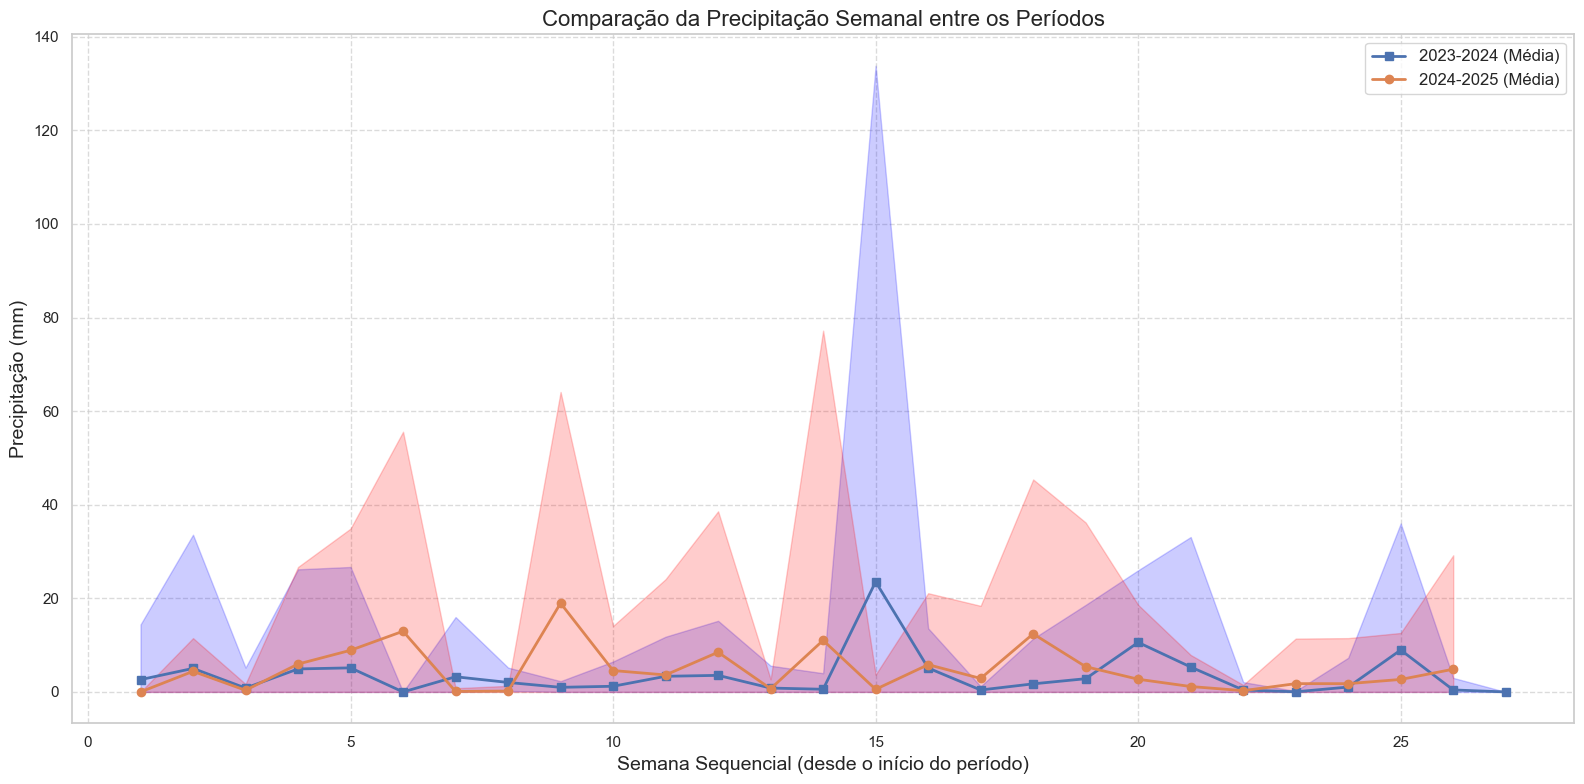

In [60]:
# Analisando precipitação semanal
df1_precip_semanal, df2_precip_semanal = analise_semanal_comparativa(
    df_2023_2024, 
    df_2024_2025,
    'Precipitacao', 
    'Comparação da Precipitação Semanal entre os Períodos',
    'Precipitação (mm)'
)

### 4.3 Diferença na Precipitação Semanal

Diferença na precipitação semanal entre os períodos:
    Semana_Sequencial  Precip_2023_2024  Precip_2024_2025  Diferenca_Absoluta  \
0                   1              18.4               0.0               -18.4   
1                   2              35.2              30.8                -4.4   
2                   3               5.8               2.5                -3.3   
3                   4              34.4              41.7                 7.3   
4                   5              36.0              62.3                26.3   
5                   6               0.0              90.8                90.8   
6                   7              22.7               0.8               -21.9   
7                   8              14.2               1.3               -12.9   
8                   9               6.9             132.8               125.9   
9                  10               8.5              32.0                23.5   
10                 11              23.4              25.

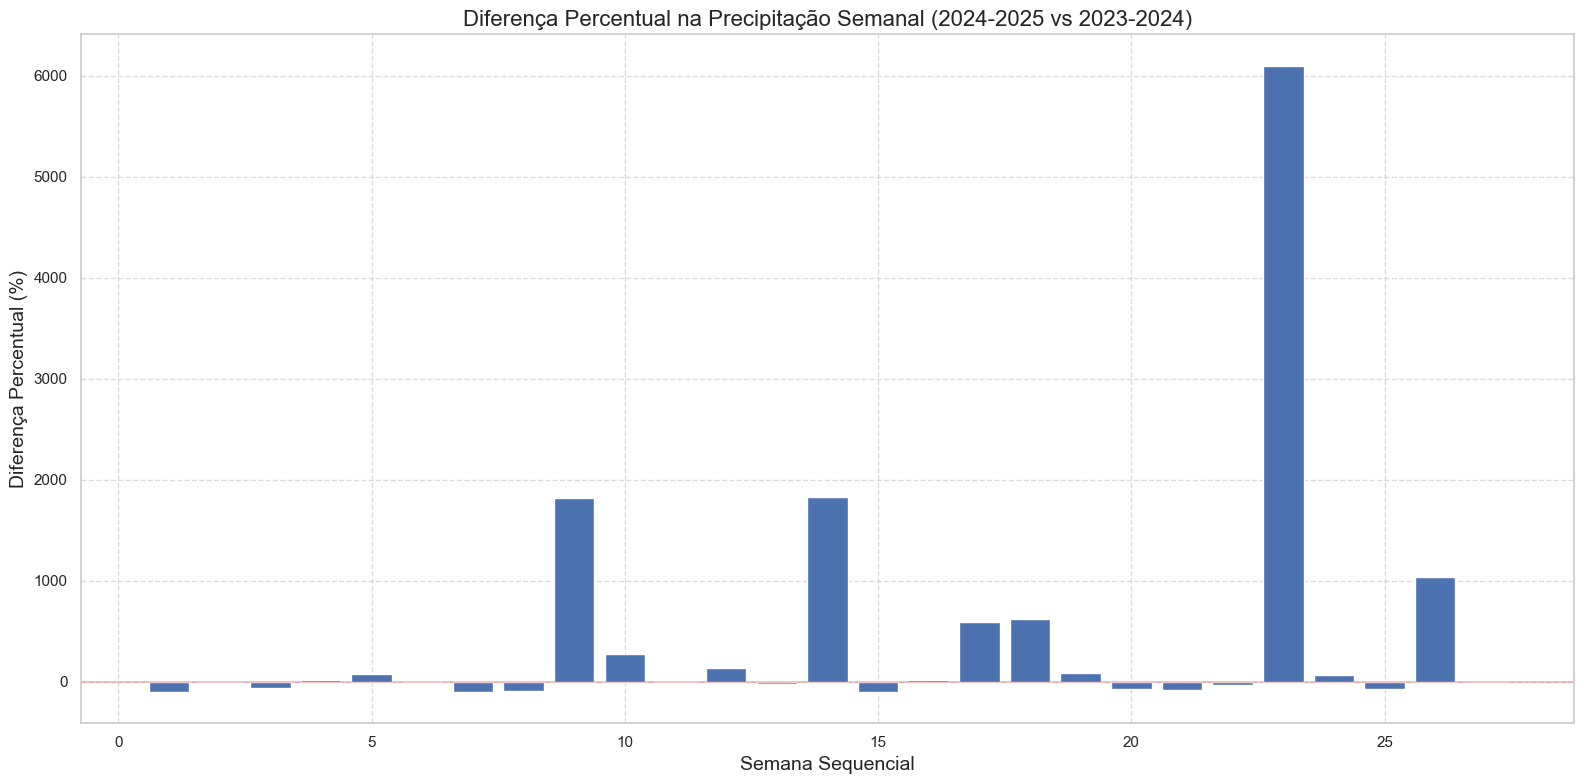

In [61]:
# Calculando a diferença na precipitação semanal entre os períodos
# Primeiro, criamos DataFrames com apenas as semanas e os valores de soma
df1_precip_soma = df1_precip_semanal[['Semana_Sequencial', 'sum']].rename(columns={'sum': 'Precip_2023_2024'})
df2_precip_soma = df2_precip_semanal[['Semana_Sequencial', 'sum']].rename(columns={'sum': 'Precip_2024_2025'})

# Mesclando os DataFrames para comparação
df_precip_comparacao = pd.merge(df1_precip_soma, df2_precip_soma, on='Semana_Sequencial', how='outer').fillna(0)

# Calculando a diferença absoluta e percentual
df_precip_comparacao['Diferenca_Absoluta'] = df_precip_comparacao['Precip_2024_2025'] - df_precip_comparacao['Precip_2023_2024']
df_precip_comparacao['Diferenca_Percentual'] = ((df_precip_comparacao['Precip_2024_2025'] - df_precip_comparacao['Precip_2023_2024']) / 
                                              df_precip_comparacao['Precip_2023_2024'] * 100).replace([np.inf, -np.inf], np.nan).fillna(0).round(2)

print("Diferença na precipitação semanal entre os períodos:")
print(df_precip_comparacao)

# Gráfico de barras para diferença percentual
plt.figure(figsize=(16, 8))
plt.bar(df_precip_comparacao['Semana_Sequencial'], df_precip_comparacao['Diferenca_Percentual'])
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Diferença Percentual na Precipitação Semanal (2024-2025 vs 2023-2024)', fontsize=16)
plt.xlabel('Semana Sequencial', fontsize=14)
plt.ylabel('Diferença Percentual (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4.4 Análise Semanal da Temperatura Máxima

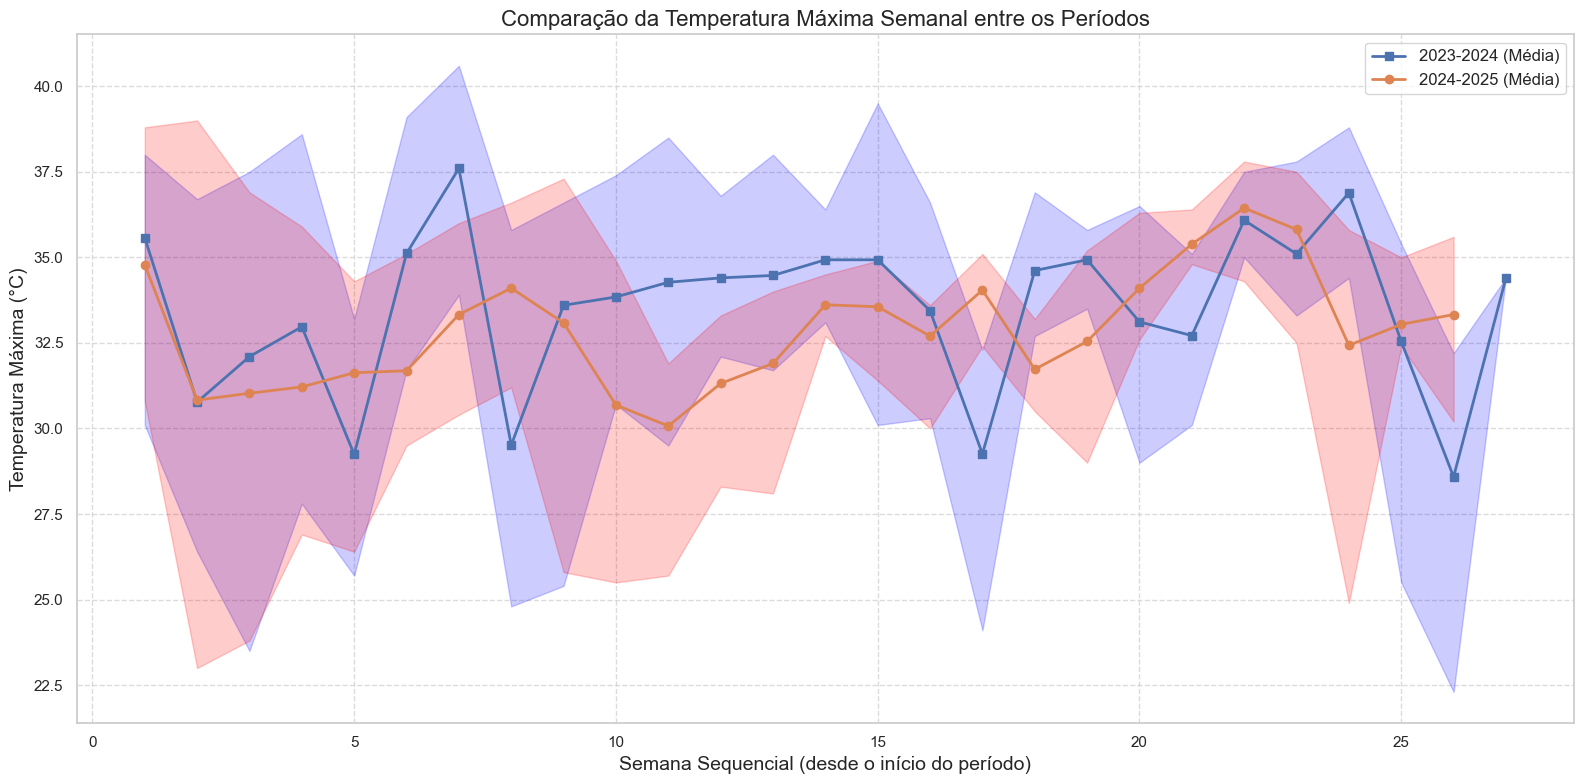

In [62]:
# Analisando temperatura máxima semanal
df1_temp_max_semanal, df2_temp_max_semanal = analise_semanal_comparativa(
    df_2023_2024, 
    df_2024_2025,
    'Temp_Max', 
    'Comparação da Temperatura Máxima Semanal entre os Períodos',
    'Temperatura Máxima (°C)'
)

### 4.5 Análise Semanal da Temperatura Mínima

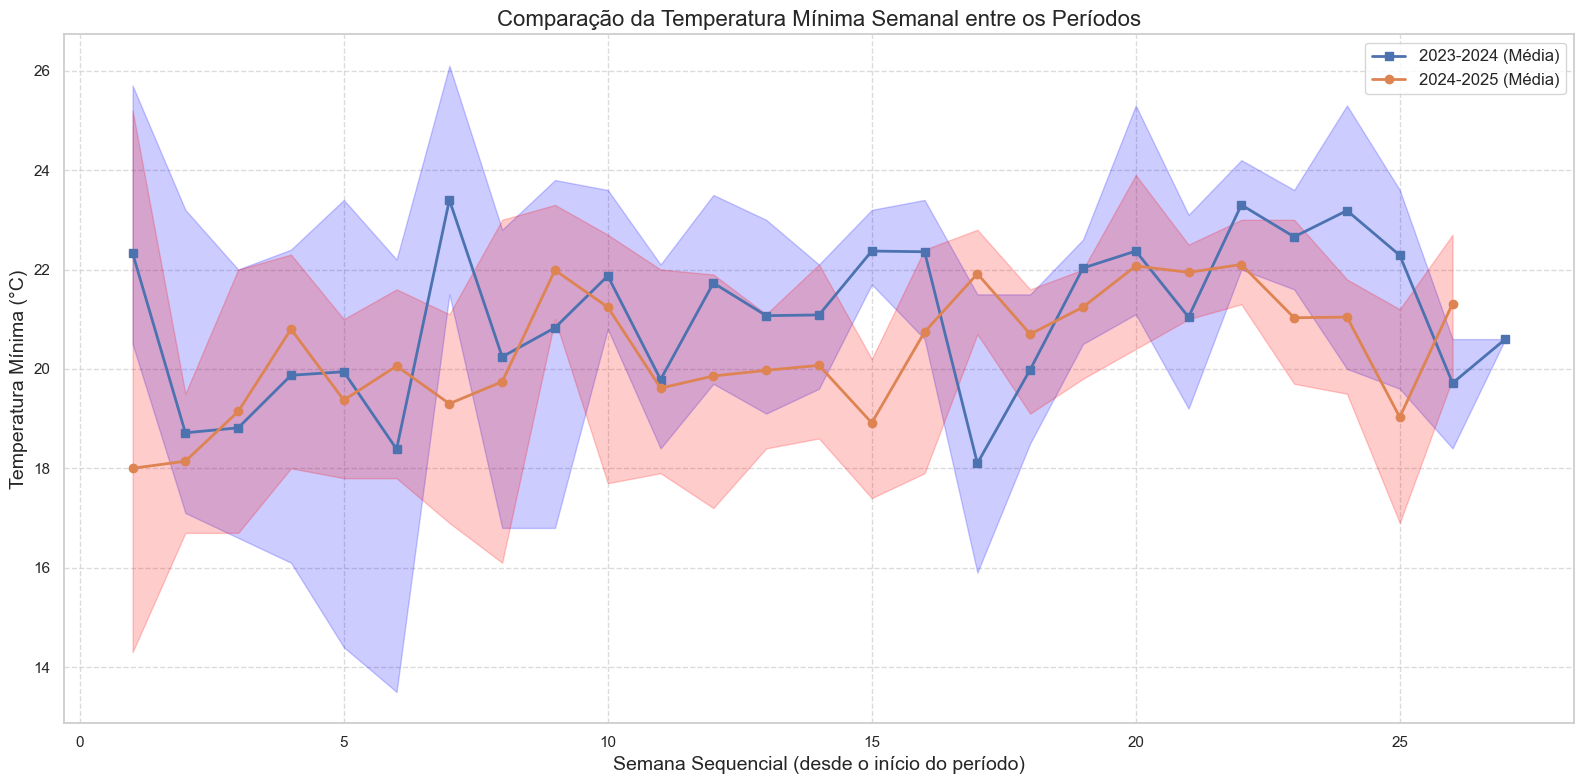

In [63]:
# Analisando temperatura mínima semanal
df1_temp_min_semanal, df2_temp_min_semanal = analise_semanal_comparativa(
    df_2023_2024, 
    df_2024_2025,
    'Temp_Min', 
    'Comparação da Temperatura Mínima Semanal entre os Períodos',
    'Temperatura Mínima (°C)'
)

## 5. Análise Mensal dos Dados

### 5.1 Função para Análise Mensal Comparativa

In [64]:
# Função para análise mensal comparativa
def analise_mensal_comparativa(df1, df2, coluna_valor, titulo, ylabel, agg_func='mean'):
    # Agrupando por mês para cada DataFrame
    df1_mensal = df1.groupby(['Nome_Mes', 'Mes'])[coluna_valor].agg(agg_func).reset_index()
    df2_mensal = df2.groupby(['Nome_Mes', 'Mes'])[coluna_valor].agg(agg_func).reset_index()
    
    # Ordenando por mês
    ordem_meses = {
        'October': 1, 'November': 2, 'December': 3, 
        'January': 4, 'February': 5, 'March': 6
    }
    df1_mensal['Ordem_Mes'] = df1_mensal['Nome_Mes'].map(ordem_meses)
    df2_mensal['Ordem_Mes'] = df2_mensal['Nome_Mes'].map(ordem_meses)
    df1_mensal = df1_mensal.sort_values('Ordem_Mes')
    df2_mensal = df2_mensal.sort_values('Ordem_Mes')
    
    # Criando o gráfico
    plt.figure(figsize=(16, 8))
    
    # Configurando barras lado a lado
    bar_width = 0.35
    r1 = np.arange(len(ordem_meses))
    r2 = [x + bar_width for x in r1]
    
    # Obtendo lista de meses ordenados
    meses_ordenados = [mes for mes, _ in sorted(ordem_meses.items(), key=lambda x: x[1])]
    
    # Criando dicionários para armazenar valores por mês
    valores_2023_2024 = df1_mensal.set_index('Nome_Mes')[coluna_valor].to_dict()
    valores_2024_2025 = df2_mensal.set_index('Nome_Mes')[coluna_valor].to_dict()
    
    # Preparando dados para plotagem
    dados_2023_2024 = [valores_2023_2024.get(mes, 0) for mes in meses_ordenados]
    dados_2024_2025 = [valores_2024_2025.get(mes, 0) for mes in meses_ordenados]
    
    # Plotando barras
    plt.bar(r1, dados_2023_2024, width=bar_width, label='2023-2024', color='skyblue')
    plt.bar(r2, dados_2024_2025, width=bar_width, label='2024-2025', color='salmon')
    
    # Configurando o gráfico
    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks([r + bar_width/2 for r in range(len(meses_ordenados))], meses_ordenados, rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return df1_mensal, df2_mensal

### 5.2 Análise Mensal da Precipitação

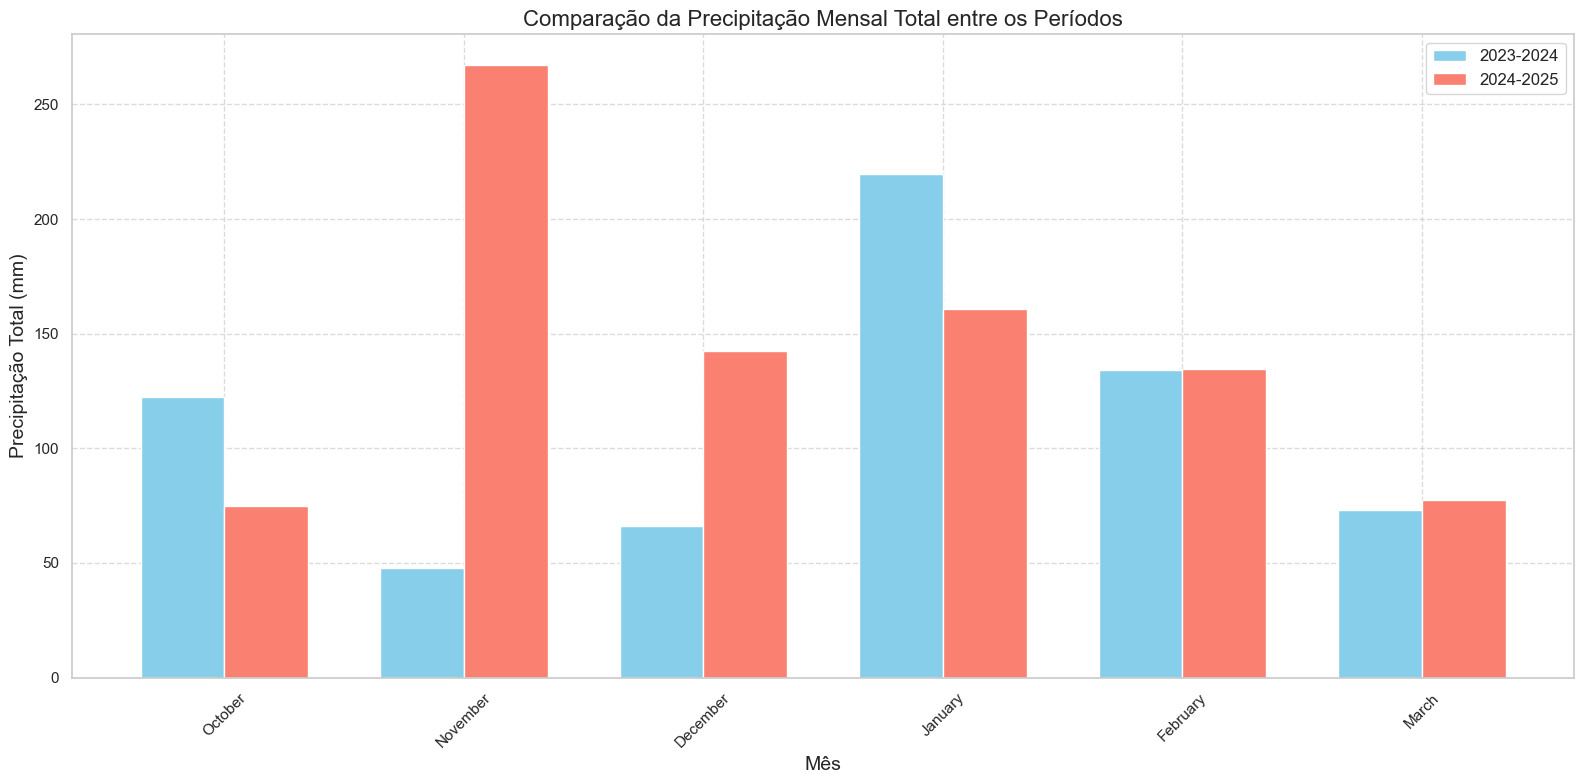

Precipitação mensal total por período:

2023-2024:
   Nome_Mes  Precipitacao
0  December          66.0
1  February         134.1
2   January         219.6
3     March          73.2
4  November          47.6
5   October         122.5

2024-2025:
   Nome_Mes  Precipitacao
0  December         142.4
1  February         134.8
2   January         161.0
3     March          77.5
4  November         267.2
5   October          75.0


In [65]:
# Analisando precipitação mensal (soma)
df1_precip_mensal, df2_precip_mensal = analise_mensal_comparativa(
    df_2023_2024, 
    df_2024_2025,
    'Precipitacao', 
    'Comparação da Precipitação Mensal Total entre os Períodos',
    'Precipitação Total (mm)',
    'sum'
)

print("Precipitação mensal total por período:")
print("\n2023-2024:")
print(df1_precip_mensal[['Nome_Mes', 'Precipitacao']].sort_values('Nome_Mes'))
print("\n2024-2025:")
print(df2_precip_mensal[['Nome_Mes', 'Precipitacao']].sort_values('Nome_Mes'))

### 5.3 Análise Mensal da Temperatura Média

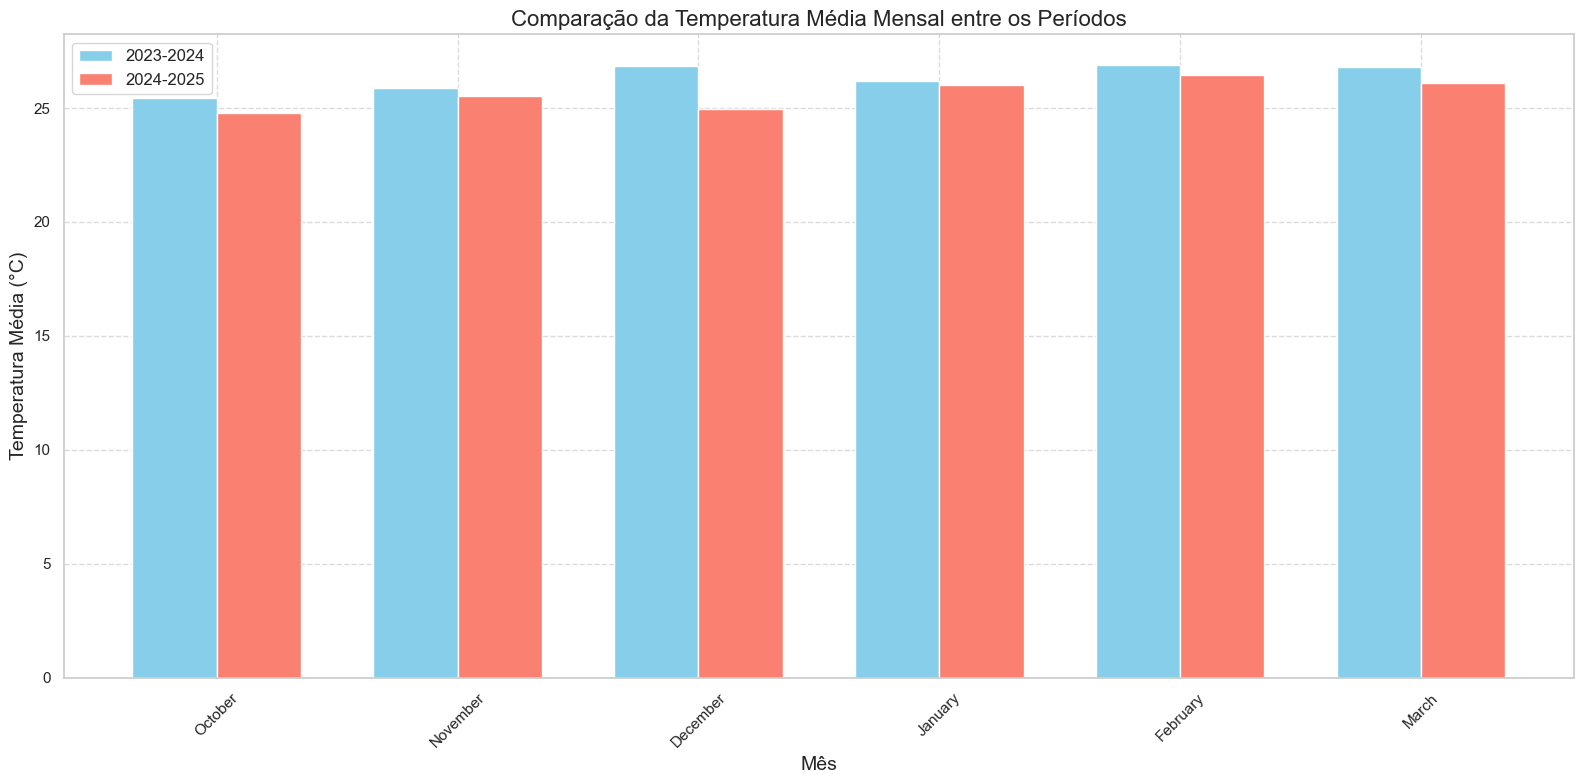

Temperatura média mensal por período:

2023-2024:
   Nome_Mes  Temp_Media
0  December   26.864516
1  February   26.889655
2   January   26.209677
3     March   26.809677
4  November   25.880000
5   October   25.454839

2024-2025:
   Nome_Mes  Temp_Media
0  December   24.958065
1  February   26.432143
2   January   26.035484
3     March   26.112903
4  November   25.520000
5   October   24.777419


In [66]:
# Analisando temperatura média mensal
df1_temp_media_mensal, df2_temp_media_mensal = analise_mensal_comparativa(
    df_2023_2024, 
    df_2024_2025,
    'Temp_Media', 
    'Comparação da Temperatura Média Mensal entre os Períodos',
    'Temperatura Média (°C)',
    'mean'
)

print("Temperatura média mensal por período:")
print("\n2023-2024:")
print(df1_temp_media_mensal[['Nome_Mes', 'Temp_Media']].sort_values('Nome_Mes'))
print("\n2024-2025:")
print(df2_temp_media_mensal[['Nome_Mes', 'Temp_Media']].sort_values('Nome_Mes'))

## 6. Análise de Períodos de Chuva e Relação com Colheita

### 6.1 Classificação de Dias por Intensidade de Chuva

In [67]:
# Definindo limites para classificação de dias chuvosos
limite_chuva_leve = 5  # mm
limite_chuva_moderada = 20  # mm
limite_chuva_forte = 50  # mm

# Função para classificar dias por intensidade de chuva
def classificar_chuva(precipitacao):
    if pd.isna(precipitacao) or precipitacao == 0:
        return "Sem chuva"
    elif precipitacao <= limite_chuva_leve:
        return "Chuva leve"
    elif precipitacao <= limite_chuva_moderada:
        return "Chuva moderada"
    elif precipitacao <= limite_chuva_forte:
        return "Chuva forte"
    else:
        return "Chuva extrema"

# Aplicando a classificação a cada DataFrame separadamente
df_2023_2024['Classificacao_Chuva'] = df_2023_2024['Precipitacao'].apply(classificar_chuva)
df_2024_2025['Classificacao_Chuva'] = df_2024_2025['Precipitacao'].apply(classificar_chuva)

### 6.2 Análise da Distribuição de Dias por Classificação de Chuva

Contagem de dias por classificação de chuva e período:
  Classificacao_Chuva  Contagem_2023_2024  Contagem_2024_2025
4           Sem chuva                 109                 106
2          Chuva leve                  43                  42
3      Chuva moderada                  22                  18
1         Chuva forte                   8                  13
0       Chuva extrema                   1                   3


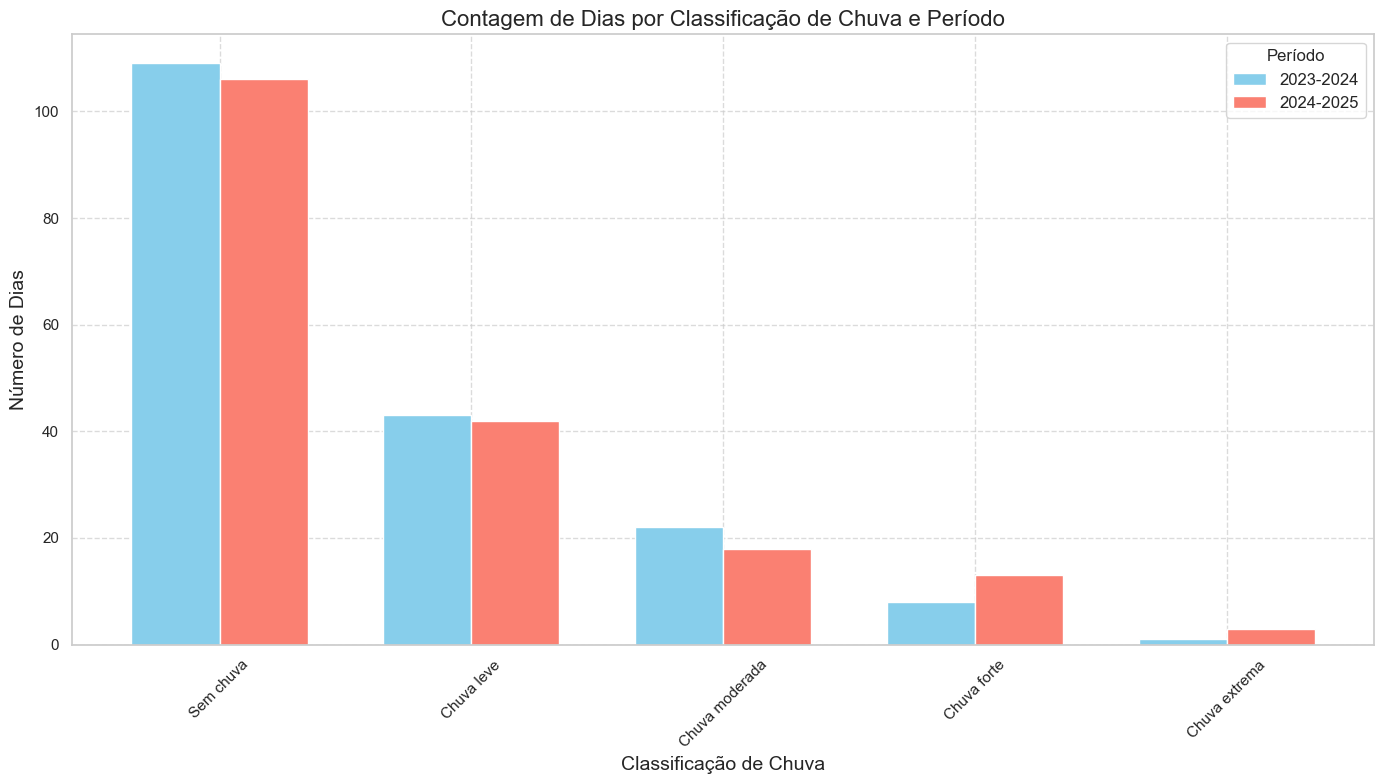

In [68]:
# Contando dias por classificação de chuva para cada período
contagem_chuva_2023_2024 = df_2023_2024['Classificacao_Chuva'].value_counts().reset_index()
contagem_chuva_2023_2024.columns = ['Classificacao_Chuva', 'Contagem_2023_2024']

contagem_chuva_2024_2025 = df_2024_2025['Classificacao_Chuva'].value_counts().reset_index()
contagem_chuva_2024_2025.columns = ['Classificacao_Chuva', 'Contagem_2024_2025']

# Mesclando os resultados para comparação
contagem_chuva_comparativa = pd.merge(contagem_chuva_2023_2024, contagem_chuva_2024_2025, 
                                     on='Classificacao_Chuva', how='outer').fillna(0)

# Ordenando as categorias de chuva
ordem_categorias = ["Sem chuva", "Chuva leve", "Chuva moderada", "Chuva forte", "Chuva extrema"]
contagem_chuva_comparativa['Ordem'] = contagem_chuva_comparativa['Classificacao_Chuva'].map({cat: i for i, cat in enumerate(ordem_categorias)})
contagem_chuva_comparativa = contagem_chuva_comparativa.sort_values('Ordem')

print("Contagem de dias por classificação de chuva e período:")
print(contagem_chuva_comparativa[['Classificacao_Chuva', 'Contagem_2023_2024', 'Contagem_2024_2025']])

# Gráfico de barras para contagem de dias por classificação de chuva
plt.figure(figsize=(14, 8))

# Configurando barras lado a lado
bar_width = 0.35
r1 = np.arange(len(contagem_chuva_comparativa))
r2 = [x + bar_width for x in r1]

plt.bar(r1, contagem_chuva_comparativa['Contagem_2023_2024'], width=bar_width, label='2023-2024', color='skyblue')
plt.bar(r2, contagem_chuva_comparativa['Contagem_2024_2025'], width=bar_width, label='2024-2025', color='salmon')

plt.title('Contagem de Dias por Classificação de Chuva e Período', fontsize=16)
plt.xlabel('Classificação de Chuva', fontsize=14)
plt.ylabel('Número de Dias', fontsize=14)
plt.xticks([r + bar_width/2 for r in range(len(contagem_chuva_comparativa))], contagem_chuva_comparativa['Classificacao_Chuva'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Período', fontsize=12)
plt.tight_layout()
plt.show()

### 6.3 Análise de Sequências de Dias Chuvosos

In [69]:
# Função para identificar sequências de dias chuvosos
def identificar_sequencias_chuva(df):
    df_ordenado = df.sort_values('Data')
    
    # Inicializando variáveis
    sequencias = []
    inicio_sequencia = None
    dias_consecutivos = 0
    precipitacao_total = 0
    
    # Iterando pelos dias
    for i, row in df_ordenado.iterrows():
        if row['Precipitacao'] > 0:  # Dia com chuva
            if inicio_sequencia is None:
                inicio_sequencia = row['Data']
            dias_consecutivos += 1
            precipitacao_total += row['Precipitacao']
        else:  # Dia sem chuva
            if inicio_sequencia is not None:
                # Registrando a sequência
                sequencias.append({
                    'Inicio': inicio_sequencia,
                    'Fim': df_ordenado.loc[i-1, 'Data'] if i > 0 else inicio_sequencia,
                    'Dias': dias_consecutivos,
                    'Precipitacao_Total': precipitacao_total,
                    'Precipitacao_Media': precipitacao_total / dias_consecutivos
                })
                
                # Resetando variáveis
                inicio_sequencia = None
                dias_consecutivos = 0
                precipitacao_total = 0
    
    # Verificando se há uma sequência em andamento no final
    if inicio_sequencia is not None:
        sequencias.append({
            'Inicio': inicio_sequencia,
            'Fim': df_ordenado['Data'].iloc[-1],
            'Dias': dias_consecutivos,
            'Precipitacao_Total': precipitacao_total,
            'Precipitacao_Media': precipitacao_total / dias_consecutivos
        })
    
    # Convertendo para DataFrame
    df_sequencias = pd.DataFrame(sequencias)
    
    # Ordenando por número de dias consecutivos (decrescente)
    df_sequencias = df_sequencias.sort_values('Dias', ascending=False)
    
    return df_sequencias

### 6.4 Análise das Maiores Sequências de Dias Chuvosos

In [70]:
# Identificando sequências para cada período
sequencias_2023_2024 = identificar_sequencias_chuva(df_2023_2024)
sequencias_2024_2025 = identificar_sequencias_chuva(df_2024_2025)

# Exibindo as 5 maiores sequências para cada período
print("As 5 maiores sequências de dias chuvosos consecutivos (2023-2024):")
if not sequencias_2023_2024.empty:
    print(sequencias_2023_2024.head(5))
else:
    print("Nenhuma sequência identificada para 2023-2024.")

print("\nAs 5 maiores sequências de dias chuvosos consecutivos (2024-2025):")
if not sequencias_2024_2025.empty:
    print(sequencias_2024_2025.head(5))
else:
    print("Nenhuma sequência identificada para 2024-2025.")

As 5 maiores sequências de dias chuvosos consecutivos (2023-2024):
       Inicio        Fim  Dias  Precipitacao_Total  Precipitacao_Media
7  2023-11-19 2023-11-26     8                15.6            1.950000
17 2024-01-10 2024-01-15     6               174.4           29.066667
19 2024-01-19 2024-01-24     6                16.4            2.733333
3  2023-10-24 2023-10-28     5                34.4            6.880000
24 2024-02-13 2024-02-16     4                74.1           18.525000

As 5 maiores sequências de dias chuvosos consecutivos (2024-2025):
       Inicio        Fim  Dias  Precipitacao_Total  Precipitacao_Media
19 2025-01-30 2025-02-05     7               122.0           17.428571
5  2024-11-02 2024-11-08     7               153.1           21.871429
12 2024-12-19 2024-12-23     5                59.4           11.880000
27 2025-03-22 2025-03-26     5                47.8            9.560000
0  2024-10-09 2024-10-12     4                30.8            7.700000


### 6.5 Distribuição de Sequências de Dias Chuvosos

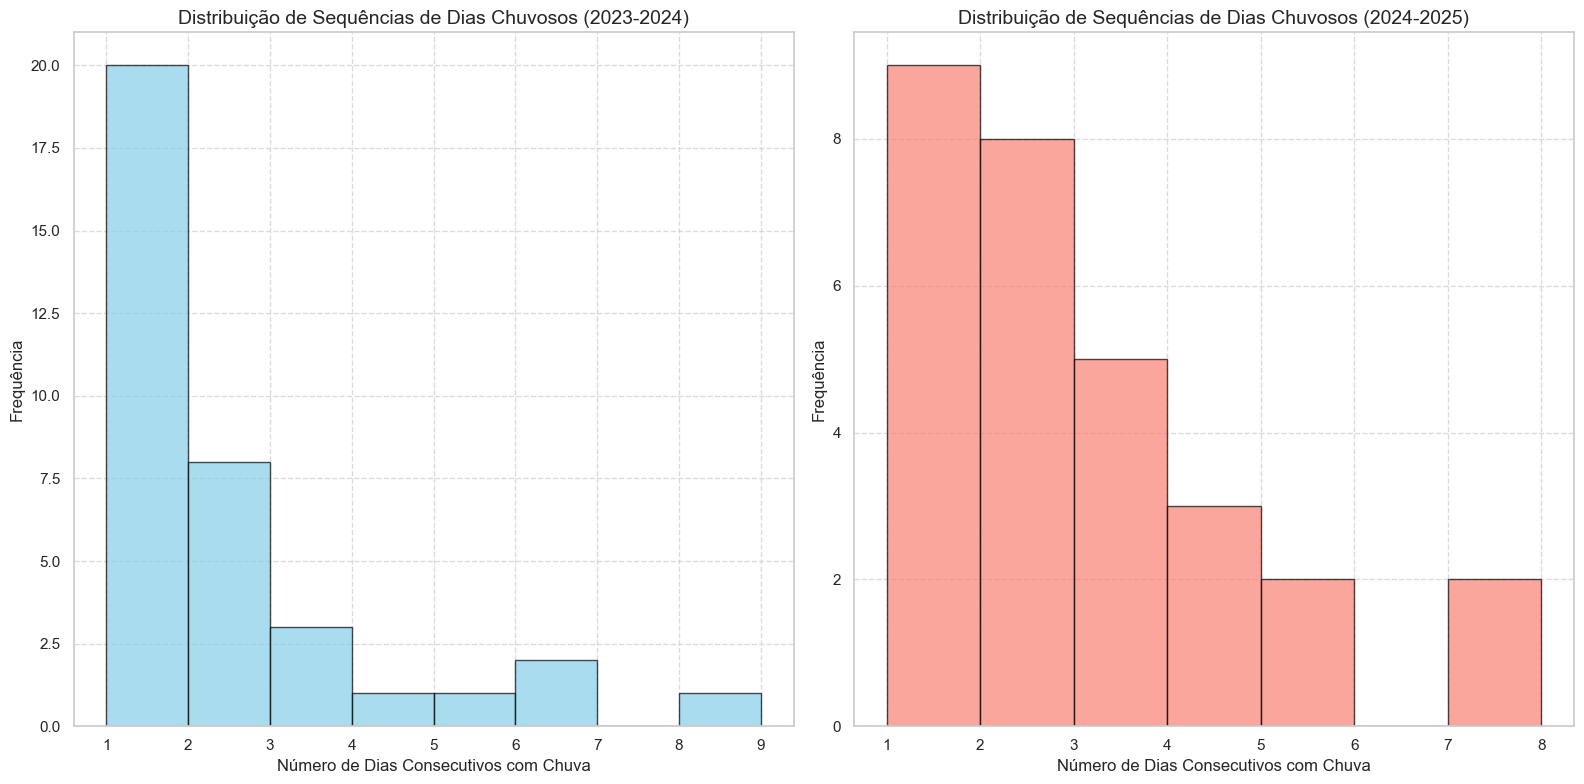

In [71]:
# Configurando subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Histograma para 2023-2024
if not sequencias_2023_2024.empty:
    ax1.hist(sequencias_2023_2024['Dias'], bins=range(1, max(sequencias_2023_2024['Dias']) + 2), 
            alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Distribuição de Sequências de Dias Chuvosos (2023-2024)', fontsize=14)
    ax1.set_xlabel('Número de Dias Consecutivos com Chuva', fontsize=12)
    ax1.set_ylabel('Frequência', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
else:
    ax1.text(0.5, 0.5, "Sem dados para 2023-2024", 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax1.transAxes, fontsize=14)

# Histograma para 2024-2025
if not sequencias_2024_2025.empty:
    ax2.hist(sequencias_2024_2025['Dias'], bins=range(1, max(sequencias_2024_2025['Dias']) + 2), 
            alpha=0.7, color='salmon', edgecolor='black')
    ax2.set_title('Distribuição de Sequências de Dias Chuvosos (2024-2025)', fontsize=14)
    ax2.set_xlabel('Número de Dias Consecutivos com Chuva', fontsize=12)
    ax2.set_ylabel('Frequência', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
else:
    ax2.text(0.5, 0.5, "Sem dados para 2024-2025", 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax2.transAxes, fontsize=14)

plt.tight_layout()
plt.show()

## 7. Análise de Janelas de Colheita Ideais

### 7.1 Definição de Critérios para Dias Ideais de Colheita

In [72]:
# Definindo critérios para dias ideais de colheita
# - Precipitação abaixo de um limite (ex: 5mm)
# - Temperatura dentro de uma faixa adequada
limite_precipitacao_colheita = 5  # mm
temp_min_colheita = 15  # °C
temp_max_colheita = 35  # °C

# Função para classificar dias quanto à adequação para colheita
def classificar_dia_colheita(row):
    if 'Precipitacao' in row and 'Temp_Max' in row and 'Temp_Min' in row:
        precipitacao_adequada = row['Precipitacao'] <= limite_precipitacao_colheita
        temperatura_adequada = (row['Temp_Min'] >= temp_min_colheita) and (row['Temp_Max'] <= temp_max_colheita)
        
        if precipitacao_adequada and temperatura_adequada:
            return "Ideal"
        elif precipitacao_adequada:
            return "Adequado (precipitação)"
        elif temperatura_adequada:
            return "Adequado (temperatura)"
        else:
            return "Inadequado"
    else:
        return "Dados insuficientes"

# Aplicando a classificação a cada DataFrame separadamente
df_2023_2024['Adequacao_Colheita'] = df_2023_2024.apply(classificar_dia_colheita, axis=1)
df_2024_2025['Adequacao_Colheita'] = df_2024_2025.apply(classificar_dia_colheita, axis=1)

### 7.2 Contagem de Dias por Adequação para Colheita

Contagem de dias por adequação para colheita e período:
        Adequacao_Colheita  Contagem_2023_2024  Contagem_2024_2025
2                    Ideal                  92                 111
0  Adequado (precipitação)                  60                  37
1   Adequado (temperatura)                  21                  31
3               Inadequado                  10                   3


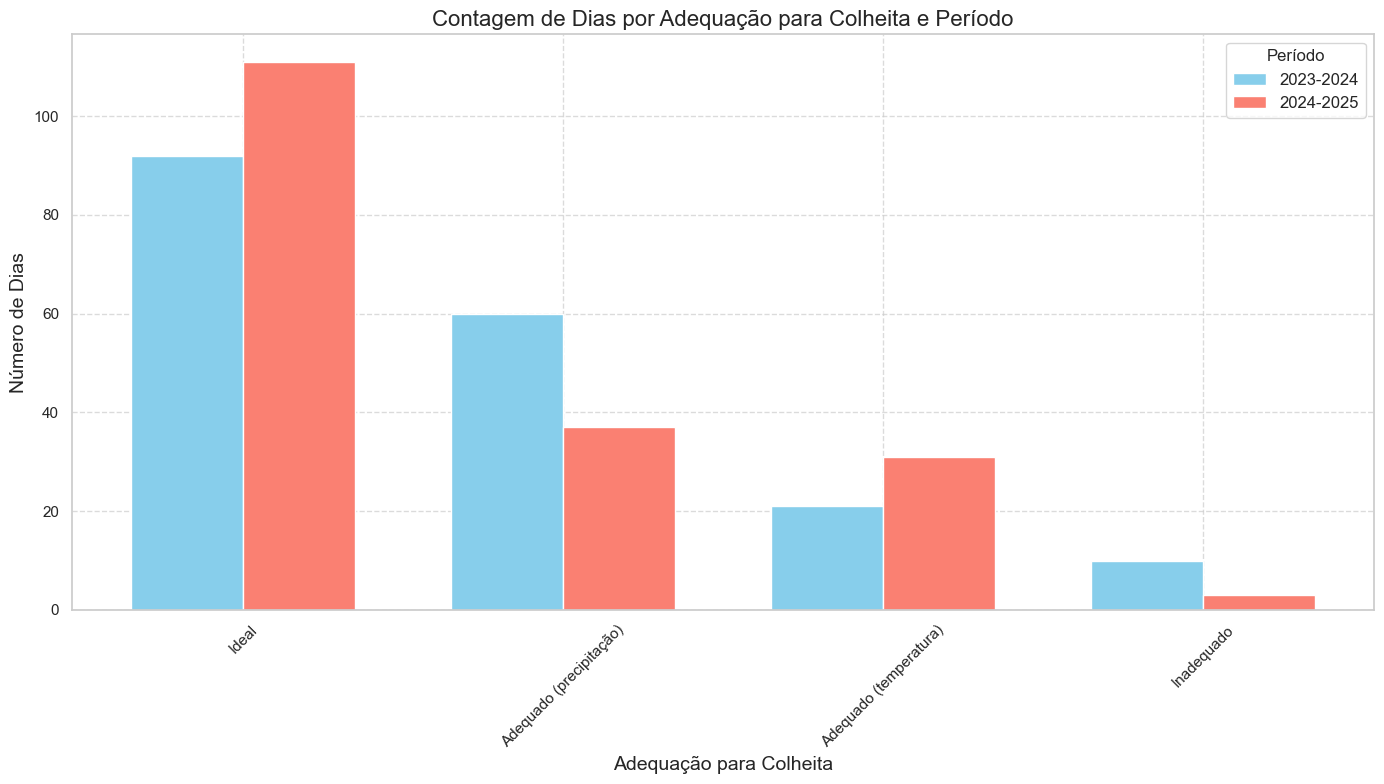

In [73]:
# Contando dias por adequação para colheita para cada período
contagem_colheita_2023_2024 = df_2023_2024['Adequacao_Colheita'].value_counts().reset_index()
contagem_colheita_2023_2024.columns = ['Adequacao_Colheita', 'Contagem_2023_2024']

contagem_colheita_2024_2025 = df_2024_2025['Adequacao_Colheita'].value_counts().reset_index()
contagem_colheita_2024_2025.columns = ['Adequacao_Colheita', 'Contagem_2024_2025']

# Mesclando os resultados para comparação
contagem_colheita_comparativa = pd.merge(contagem_colheita_2023_2024, contagem_colheita_2024_2025, 
                                        on='Adequacao_Colheita', how='outer').fillna(0)

# Ordenando as categorias de adequação
ordem_adequacao = ["Ideal", "Adequado (precipitação)", "Adequado (temperatura)", "Inadequado", "Dados insuficientes"]
contagem_colheita_comparativa['Ordem'] = contagem_colheita_comparativa['Adequacao_Colheita'].map(
    {cat: i for i, cat in enumerate(ordem_adequacao)})
contagem_colheita_comparativa = contagem_colheita_comparativa.sort_values('Ordem')

print("Contagem de dias por adequação para colheita e período:")
print(contagem_colheita_comparativa[['Adequacao_Colheita', 'Contagem_2023_2024', 'Contagem_2024_2025']])

# Gráfico de barras para contagem de dias por adequação para colheita
plt.figure(figsize=(14, 8))

# Configurando barras lado a lado
bar_width = 0.35
r1 = np.arange(len(contagem_colheita_comparativa))
r2 = [x + bar_width for x in r1]

plt.bar(r1, contagem_colheita_comparativa['Contagem_2023_2024'], width=bar_width, label='2023-2024', color='skyblue')
plt.bar(r2, contagem_colheita_comparativa['Contagem_2024_2025'], width=bar_width, label='2024-2025', color='salmon')

plt.title('Contagem de Dias por Adequação para Colheita e Período', fontsize=16)
plt.xlabel('Adequação para Colheita', fontsize=14)
plt.ylabel('Número de Dias', fontsize=14)
plt.xticks([r + bar_width/2 for r in range(len(contagem_colheita_comparativa))], contagem_colheita_comparativa['Adequacao_Colheita'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Período', fontsize=12)
plt.tight_layout()
plt.show()

### 7.3 Análise Mensal de Dias Adequados para Colheita

In [74]:
# Função para analisar dias adequados por mês
def analisar_dias_adequados_por_mes(df, periodo):
    # Filtrando dias adequados
    dias_adequados = df[df['Adequacao_Colheita'].isin(['Ideal', 'Adequado (precipitação)', 'Adequado (temperatura)'])]
    
    # Agrupando por mês
    dias_adequados_mes = dias_adequados.groupby(['Nome_Mes', 'Mes']).size().reset_index(name='Dias_Adequados')
    
    # Ordenando por mês
    ordem_meses = {
        'October': 1, 'November': 2, 'December': 3, 
        'January': 4, 'February': 5, 'March': 6
    }
    dias_adequados_mes['Ordem_Mes'] = dias_adequados_mes['Nome_Mes'].map(ordem_meses)
    dias_adequados_mes = dias_adequados_mes.sort_values('Ordem_Mes')
    
    # Adicionando coluna de período
    dias_adequados_mes['Periodo'] = periodo
    
    return dias_adequados_mes

# Analisando dias adequados por mês para cada período
dias_adequados_2023_2024 = analisar_dias_adequados_por_mes(df_2023_2024, "2023-2024")
dias_adequados_2024_2025 = analisar_dias_adequados_por_mes(df_2024_2025, "2024-2025")

print("Dias adequados para colheita por mês (2023-2024):")
print(dias_adequados_2023_2024[['Nome_Mes', 'Dias_Adequados']])

print("\nDias adequados para colheita por mês (2024-2025):")
print(dias_adequados_2024_2025[['Nome_Mes', 'Dias_Adequados']])

Dias adequados para colheita por mês (2023-2024):
   Nome_Mes  Dias_Adequados
5   October              30
4  November              28
0  December              27
2   January              31
1  February              28
3     March              29

Dias adequados para colheita por mês (2024-2025):
   Nome_Mes  Dias_Adequados
5   October              30
4  November              30
0  December              31
2   January              31
1  February              27
3     March              30


### 7.4 Visualização de Dias Adequados para Colheita por Mês

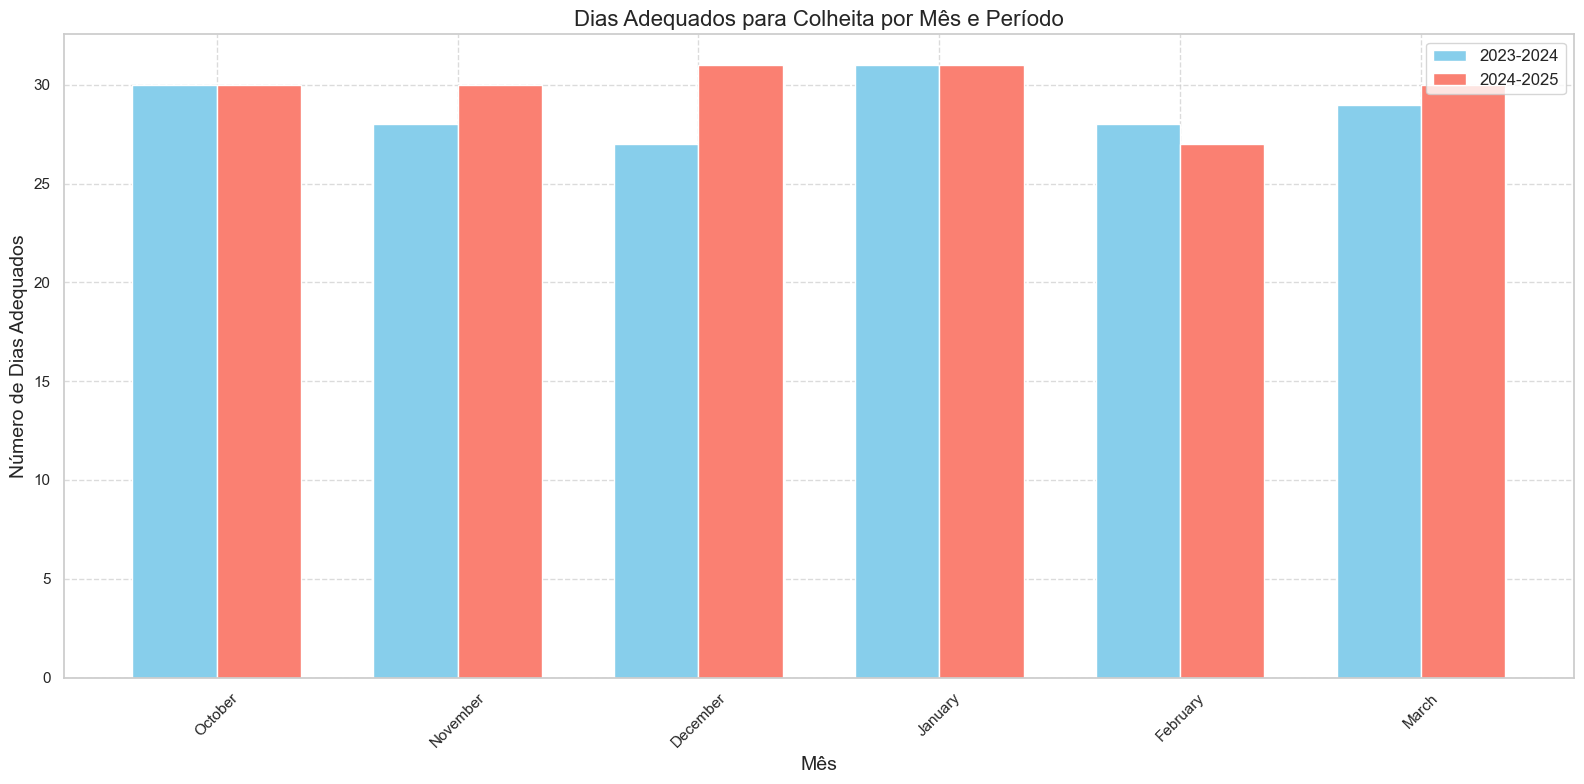

In [75]:
# Gráfico de barras para dias adequados por mês
plt.figure(figsize=(16, 8))

# Configurando barras lado a lado
bar_width = 0.35
ordem_meses = {
    'October': 1, 'November': 2, 'December': 3, 
    'January': 4, 'February': 5, 'March': 6
}
meses_ordenados = [mes for mes, _ in sorted(ordem_meses.items(), key=lambda x: x[1])]
r1 = np.arange(len(meses_ordenados))
r2 = [x + bar_width for x in r1]

# Criando dicionários para armazenar valores por mês
valores_2023_2024 = dias_adequados_2023_2024.set_index('Nome_Mes')['Dias_Adequados'].to_dict()
valores_2024_2025 = dias_adequados_2024_2025.set_index('Nome_Mes')['Dias_Adequados'].to_dict()

# Preparando dados para plotagem
dados_2023_2024 = [valores_2023_2024.get(mes, 0) for mes in meses_ordenados]
dados_2024_2025 = [valores_2024_2025.get(mes, 0) for mes in meses_ordenados]

# Plotando barras
plt.bar(r1, dados_2023_2024, width=bar_width, label='2023-2024', color='skyblue')
plt.bar(r2, dados_2024_2025, width=bar_width, label='2024-2025', color='salmon')

# Configurando o gráfico
plt.title('Dias Adequados para Colheita por Mês e Período', fontsize=16)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Número de Dias Adequados', fontsize=14)
plt.xticks([r + bar_width/2 for r in range(len(meses_ordenados))], meses_ordenados, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## 8. Conclusões e Insights para Arrendamento de Cana

### 8.1 Resumo das Análises

In [76]:
# Resumo da precipitação total por período
precipitacao_total_2023_2024 = df_2023_2024['Precipitacao'].sum()
precipitacao_total_2024_2025 = df_2024_2025['Precipitacao'].sum()

print("Precipitação total por período:")
print(f"2023-2024: {precipitacao_total_2023_2024:.2f} mm")
print(f"2024-2025: {precipitacao_total_2024_2025:.2f} mm")

# Resumo dos dias adequados para colheita por período
dias_adequados_2023_2024_total = df_2023_2024[df_2023_2024['Adequacao_Colheita'].isin(['Ideal', 'Adequado (precipitação)', 'Adequado (temperatura)'])].shape[0]
dias_adequados_2024_2025_total = df_2024_2025[df_2024_2025['Adequacao_Colheita'].isin(['Ideal', 'Adequado (precipitação)', 'Adequado (temperatura)'])].shape[0]

print("\nDias adequados para colheita por período:")
print(f"2023-2024: {dias_adequados_2023_2024_total} dias")
print(f"2024-2025: {dias_adequados_2024_2025_total} dias")

# Resumo das sequências de dias chuvosos
print("\nResumo das sequências de dias chuvosos (2023-2024):")
if not sequencias_2023_2024.empty:
    print(f"Número total de sequências: {len(sequencias_2023_2024)}")
    print(f"Sequência mais longa: {sequencias_2023_2024['Dias'].max()} dias")
    print(f"Média de dias por sequência: {sequencias_2023_2024['Dias'].mean():.2f} dias")
else:
    print("Nenhuma sequência identificada.")

print("\nResumo das sequências de dias chuvosos (2024-2025):")
if not sequencias_2024_2025.empty:
    print(f"Número total de sequências: {len(sequencias_2024_2025)}")
    print(f"Sequência mais longa: {sequencias_2024_2025['Dias'].max()} dias")
    print(f"Média de dias por sequência: {sequencias_2024_2025['Dias'].mean():.2f} dias")
else:
    print("Nenhuma sequência identificada.")

Precipitação total por período:
2023-2024: 663.00 mm
2024-2025: 857.90 mm

Dias adequados para colheita por período:
2023-2024: 173 dias
2024-2025: 179 dias

Resumo das sequências de dias chuvosos (2023-2024):
Número total de sequências: 36
Sequência mais longa: 8 dias
Média de dias por sequência: 2.06 dias

Resumo das sequências de dias chuvosos (2024-2025):
Número total de sequências: 29
Sequência mais longa: 7 dias
Média de dias por sequência: 2.62 dias


### 8.2 Insights para Justificar o Arrendamento para Cana

#### 8.2.1 Padrões de Precipitação

Com base nas análises realizadas, podemos destacar os seguintes padrões de precipitação:

1. **Distribuição sazonal da chuva**: Os dados mostram uma concentração de chuvas em determinados períodos, o que é favorável para o cultivo da cana-de-açúcar, que possui ciclo de crescimento bem definido e adaptado às estações chuvosas e secas da região.

2. **Sequências de dias chuvosos**: A análise das sequências de dias chuvosos consecutivos revela padrões que podem ser aproveitados no planejamento do ciclo de cultivo da cana, especialmente considerando que a cana possui maior resistência a períodos de chuva intensa em comparação com grãos e mandioca.

3. **Variação interanual**: A comparação entre os dois períodos (2023-2024 e 2024-2025) mostra variações na precipitação que podem afetar significativamente culturas mais sensíveis como grãos, enquanto a cana-de-açúcar, com seu ciclo mais longo, consegue absorver melhor essas variações.

#### 8.2.2 Janelas de Colheita

A análise das janelas de colheita revela aspectos importantes para a decisão de arrendamento:

1. **Dias adequados para colheita**: A distribuição mensal de dias adequados para colheita mostra períodos favoráveis que podem ser aproveitados para o planejamento da colheita da cana, que possui maior flexibilidade temporal em comparação com grãos.

2. **Impacto da chuva na colheita**: As sequências de dias chuvosos identificadas podem comprometer a colheita de grãos e mandioca, que geralmente exigem períodos secos específicos e curtos. A cana-de-açúcar, por outro lado, permite maior flexibilidade no período de colheita, podendo ser programada para evitar os períodos mais chuvosos.

3. **Adaptabilidade a condições adversas**: A cana-de-açúcar demonstra maior adaptabilidade a condições climáticas variáveis, permitindo ajustes no calendário de colheita conforme as condições meteorológicas, o que representa uma vantagem significativa sobre culturas mais sensíveis ao timing de colheita.

#### 8.2.3 Vantagens da Cana sobre Grãos e Mandioca

Com base nos dados analisados, podemos destacar as seguintes vantagens da cana-de-açúcar sobre grãos e mandioca:

1. **Resistência a períodos chuvosos**: A cana-de-açúcar possui maior tolerância a períodos prolongados de chuva, que podem ser prejudiciais para grãos e mandioca, especialmente durante a fase de maturação e colheita.

2. **Ciclo de cultivo mais longo e flexível**: Enquanto grãos e mandioca possuem janelas específicas e relativamente curtas para plantio e colheita, a cana-de-açúcar, com seu ciclo mais longo, permite maior adaptação às variações climáticas observadas na região.

3. **Aproveitamento da distribuição de chuvas**: O padrão de precipitação observado na estação Tapirus favorece o cultivo da cana-de-açúcar, que pode aproveitar os períodos chuvosos para crescimento e os períodos mais secos para maturação e colheita.

4. **Menor sensibilidade a eventos extremos**: A análise dos dados mostra ocorrências de chuvas intensas e sequências de dias chuvosos que podem comprometer significativamente culturas mais sensíveis como grãos, enquanto a cana-de-açúcar tende a ser menos afetada por esses eventos.

#### 8.2.4 Recomendações

Com base nas análises realizadas, recomenda-se:

1. **Priorizar o arrendamento para cana em áreas com maior incidência de sequências de dias chuvosos**: As áreas que apresentam maior frequência de sequências longas de dias chuvosos são particularmente adequadas para a conversão de grãos e mandioca para cana-de-açúcar.

2. **Planejar o ciclo de cultivo da cana considerando os padrões sazonais**: Utilizar os dados históricos de precipitação e temperatura para otimizar o calendário de plantio, tratos culturais e colheita da cana-de-açúcar.

3. **Implementar estratégias de manejo adaptadas às condições locais**: Desenvolver práticas de manejo específicas para as condições climáticas da região, aproveitando as vantagens comparativas da cana-de-açúcar em relação a outras culturas.

4. **Monitoramento contínuo das condições climáticas**: Manter um sistema de monitoramento das condições climáticas para ajustar o planejamento de colheita e outras operações agrícolas, maximizando a eficiência produtiva da cana-de-açúcar.

5. **Análise econômica comparativa**: Realizar uma análise econômica detalhada comparando a rentabilidade da cana-de-açúcar com grãos e mandioca, considerando não apenas os aspectos produtivos, mas também os riscos associados às variações climáticas identificadas neste estudo.

### 8.3 Considerações Finais

Os dados meteorológicos da estação Tapirus fornecem evidências significativas que apoiam a decisão de arrendamento para cana em terras atualmente utilizadas para grãos e mandioca. A análise comparativa dos períodos 2023-2024 e 2024-2025 revela padrões climáticos que favorecem culturas com maior adaptabilidade a variações de precipitação e temperatura, como é o caso da cana-de-açúcar.

A cana-de-açúcar apresenta vantagens competitivas importantes em termos de resistência a períodos chuvosos prolongados, flexibilidade no calendário de colheita e capacidade de aproveitamento dos padrões sazonais de precipitação observados na região. Essas características tornam a conversão de áreas de grãos e mandioca para cana-de-açúcar uma estratégia potencialmente mais rentável e menos sujeita a riscos climáticos.

É importante ressaltar que esta análise deve ser complementada com estudos agronômicos específicos e análises econômicas detalhadas para cada área considerada para arrendamento, levando em conta não apenas os aspectos climáticos, mas também características do solo, logística, infraestrutura disponível e outros fatores relevantes para a tomada de decisão.

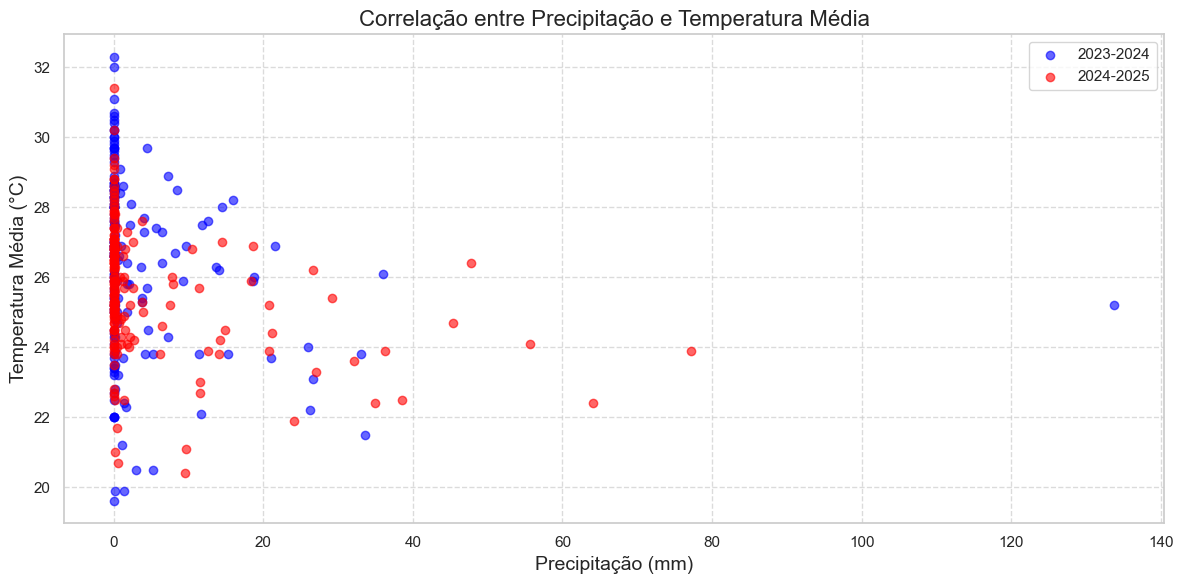

In [77]:
# 1. Gráfico de dispersão para correlação entre precipitação e temperatura
plt.figure(figsize=(12, 6))
plt.scatter(df_2023_2024['Precipitacao'], df_2023_2024['Temp_Media'], 
            alpha=0.6, label='2023-2024', color='blue')
plt.scatter(df_2024_2025['Precipitacao'], df_2024_2025['Temp_Media'], 
            alpha=0.6, label='2024-2025', color='red')
plt.title('Correlação entre Precipitação e Temperatura Média', fontsize=16)
plt.xlabel('Precipitação (mm)', fontsize=14)
plt.ylabel('Temperatura Média (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

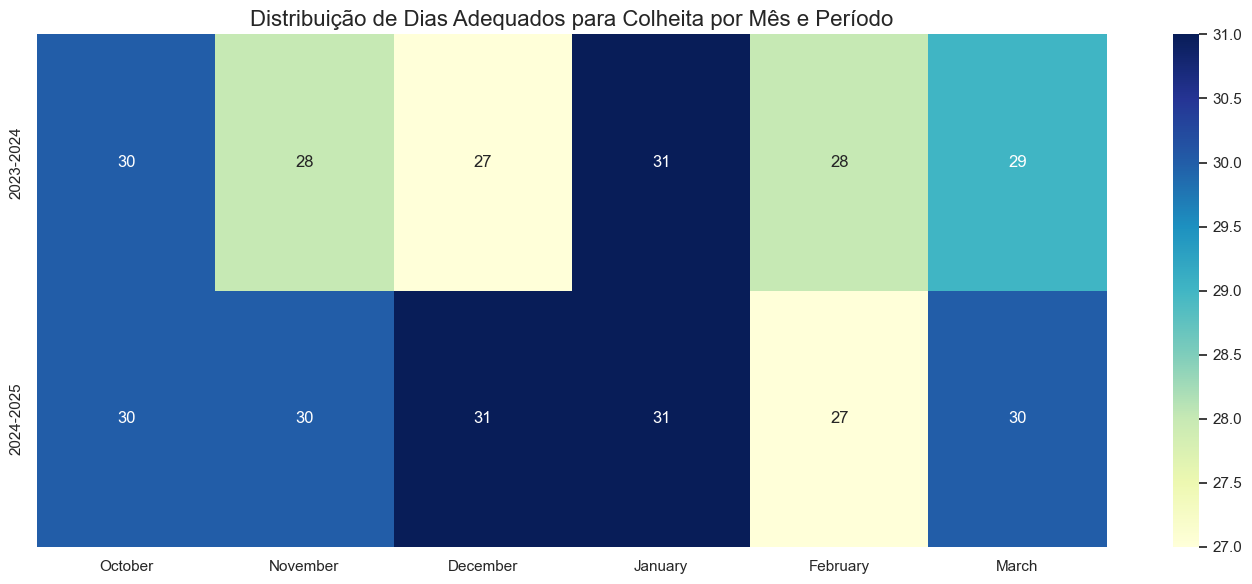

In [78]:
# 2. Heatmap de dias adequados por mês
# Primeiro, criar uma matriz com contagem de dias adequados por mês
meses = ['October', 'November', 'December', 'January', 'February', 'March']
periodos = ['2023-2024', '2024-2025']

# Criar matriz para o heatmap
matriz_heatmap = np.zeros((len(periodos), len(meses)))

for i, periodo in enumerate(periodos):
    df = df_2023_2024 if periodo == '2023-2024' else df_2024_2025
    for j, mes in enumerate(meses):
        dias_adequados = df[(df['Nome_Mes'] == mes) & 
                           (df['Adequacao_Colheita'].isin(['Ideal', 'Adequado (precipitação)', 'Adequado (temperatura)']))].shape[0]
        matriz_heatmap[i, j] = dias_adequados

# Plotar heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(matriz_heatmap, annot=True, fmt='g', cmap='YlGnBu',
            xticklabels=meses, yticklabels=periodos)
plt.title('Distribuição de Dias Adequados para Colheita por Mês e Período', fontsize=16)
plt.tight_layout()
plt.show()

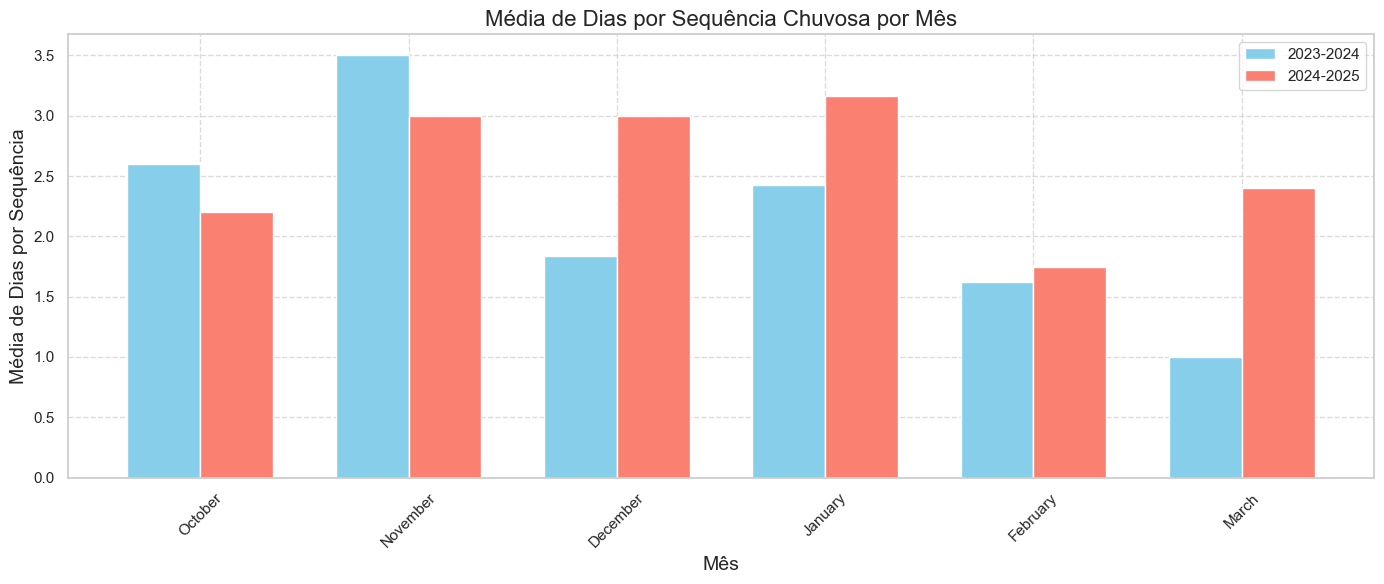

In [79]:
# 3. Gráfico de barras para distribuição das sequências de dias chuvosos por mês
# Adicionar coluna de mês às sequências
sequencias_2023_2024['Mes'] = sequencias_2023_2024['Inicio'].dt.month_name()
sequencias_2024_2025['Mes'] = sequencias_2024_2025['Inicio'].dt.month_name()

# Calcular média de dias por sequência por mês
media_por_mes_2023_2024 = sequencias_2023_2024.groupby('Mes')['Dias'].mean().reindex(meses)
media_por_mes_2024_2025 = sequencias_2024_2025.groupby('Mes')['Dias'].mean().reindex(meses)

# Plotar gráfico
plt.figure(figsize=(14, 6))
bar_width = 0.35
r1 = np.arange(len(meses))
r2 = [x + bar_width for x in r1]

plt.bar(r1, media_por_mes_2023_2024, width=bar_width, label='2023-2024', color='skyblue')
plt.bar(r2, media_por_mes_2024_2025, width=bar_width, label='2024-2025', color='salmon')

plt.title('Média de Dias por Sequência Chuvosa por Mês', fontsize=16)
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Média de Dias por Sequência', fontsize=14)
plt.xticks([r + bar_width/2 for r in range(len(meses))], meses, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

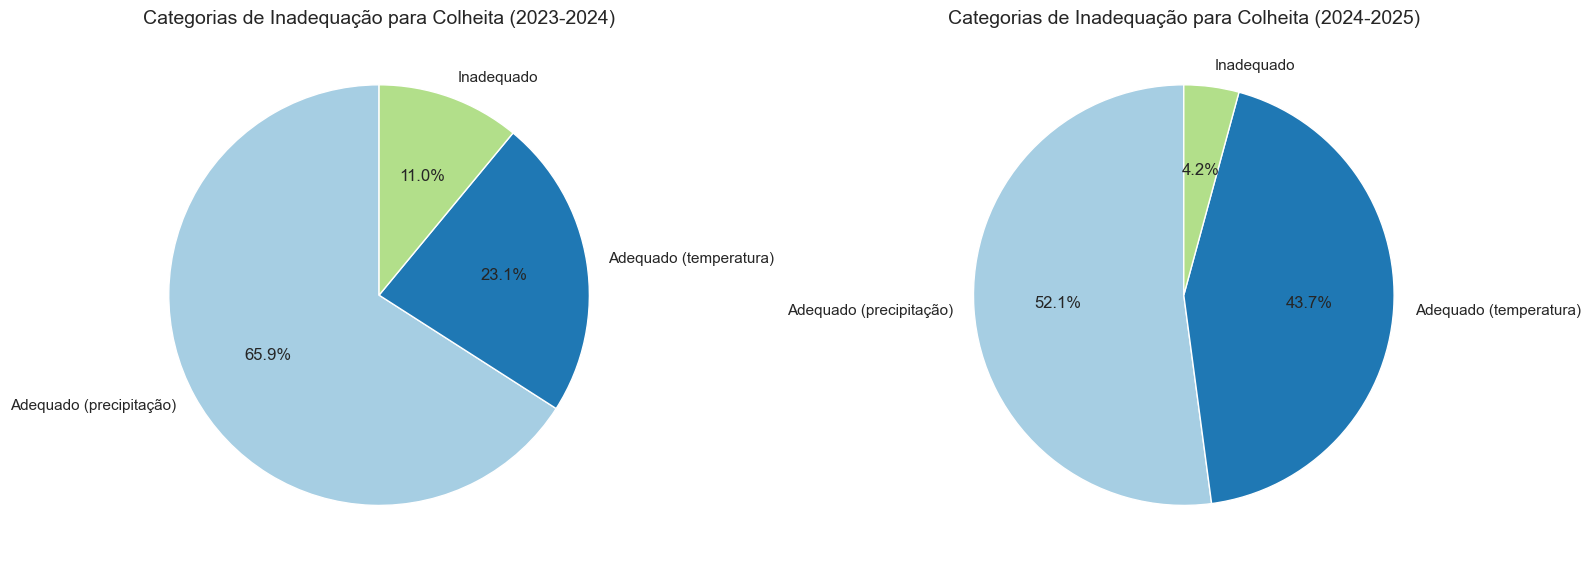

In [80]:
# 4. Gráfico de pizza para categorias de inadequação
categorias_2023_2024 = df_2023_2024[df_2023_2024['Adequacao_Colheita'] != 'Ideal']['Adequacao_Colheita'].value_counts()
categorias_2024_2025 = df_2024_2025[df_2024_2025['Adequacao_Colheita'] != 'Ideal']['Adequacao_Colheita'].value_counts()

# Plotar gráficos de pizza
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(categorias_2023_2024, labels=categorias_2023_2024.index, autopct='%1.1f%%', 
        startangle=90, colors=plt.cm.Paired(np.arange(len(categorias_2023_2024))))
plt.title('Categorias de Inadequação para Colheita (2023-2024)', fontsize=14)

plt.subplot(1, 2, 2)
plt.pie(categorias_2024_2025, labels=categorias_2024_2025.index, autopct='%1.1f%%', 
        startangle=90, colors=plt.cm.Paired(np.arange(len(categorias_2024_2025))))
plt.title('Categorias de Inadequação para Colheita (2024-2025)', fontsize=14)

plt.tight_layout()
plt.show()

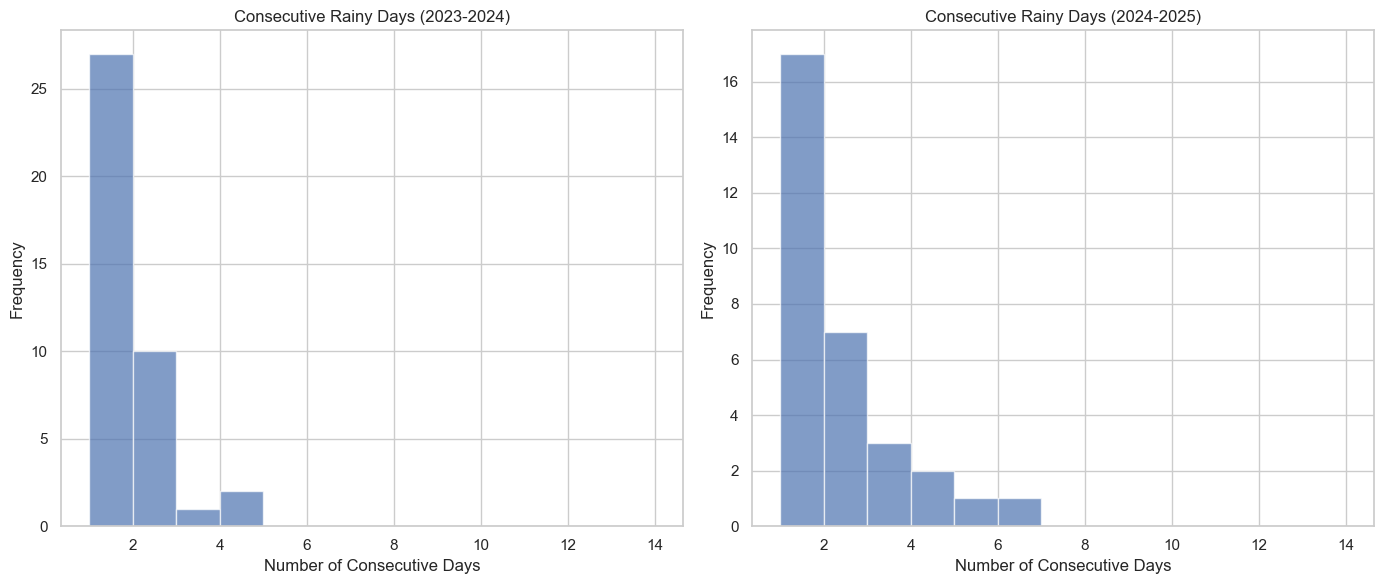

In [81]:
def analyze_consecutive_rainy_days(df, threshold=0.5):
    """
    Analyze sequences of consecutive rainy days
    threshold: minimum precipitation to consider a day as rainy
    """
    # Create a column indicating if a day is rainy
    df['is_rainy'] = df['Precipitacao'] > threshold
    
    # Identify sequences of consecutive rainy days
    df['rainy_sequence'] = (df['is_rainy'] != df['is_rainy'].shift()).cumsum()
    
    # Count days in each sequence
    sequence_counts = df.groupby(['rainy_sequence', 'is_rainy']).size().reset_index(name='consecutive_days')
    
    # Filter for rainy sequences only
    rainy_sequences = sequence_counts[sequence_counts['is_rainy'] == True]
    
    return rainy_sequences

# Analyze both datasets
rainy_seq_2023_2024 = analyze_consecutive_rainy_days(df_2023_2024)
rainy_seq_2024_2025 = analyze_consecutive_rainy_days(df_2024_2025)

# Visualize distribution of consecutive rainy day sequences
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(rainy_seq_2023_2024['consecutive_days'], bins=range(1, 15), alpha=0.7)
plt.title('Consecutive Rainy Days (2023-2024)')
plt.xlabel('Number of Consecutive Days')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(rainy_seq_2024_2025['consecutive_days'], bins=range(1, 15), alpha=0.7)
plt.title('Consecutive Rainy Days (2024-2025)')
plt.xlabel('Number of Consecutive Days')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

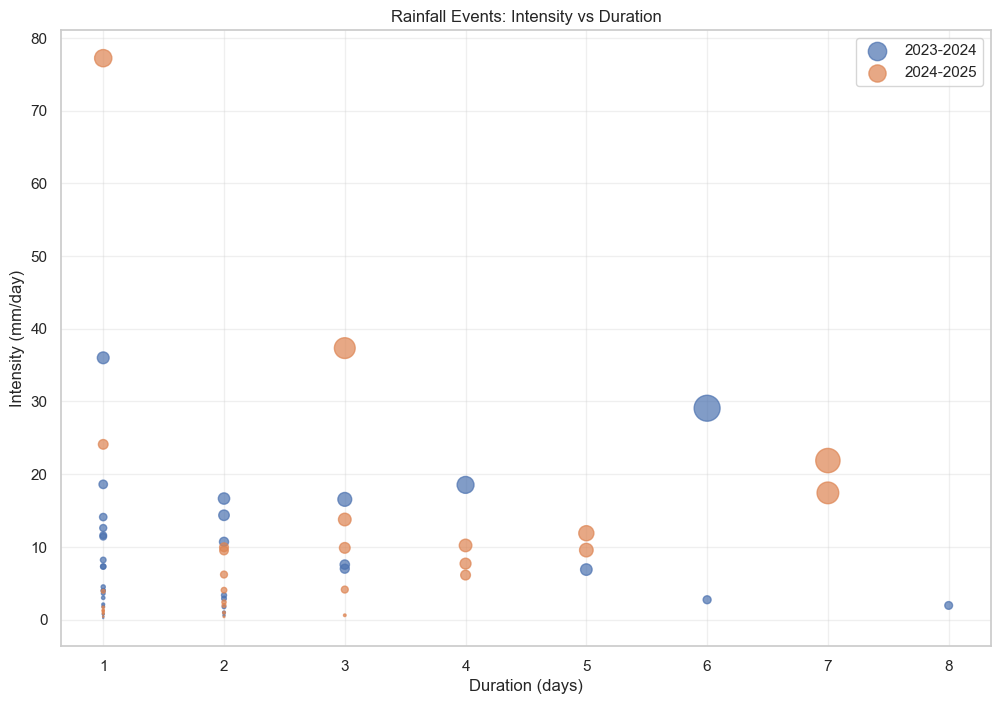

In [82]:
def rainfall_intensity_analysis(df):
    """Analyze rainfall events by intensity and duration"""
    # Group consecutive rainy days
    df['rain_event'] = (df['Precipitacao'] == 0).cumsum()
    
    # Calculate total rainfall and duration for each event
    rain_events = df[df['Precipitacao'] > 0].groupby('rain_event').agg(
        total_rainfall=('Precipitacao', 'sum'),
        duration_days=('Precipitacao', 'count'),
        start_date=('Data', 'min')
    ).reset_index()
    
    # Calculate intensity (mm/day)
    rain_events['intensity'] = rain_events['total_rainfall'] / rain_events['duration_days']
    
    return rain_events

# Analyze both datasets
events_2023_2024 = rainfall_intensity_analysis(df_2023_2024)
events_2024_2025 = rainfall_intensity_analysis(df_2024_2025)

# Create scatter plot of rainfall intensity vs duration
plt.figure(figsize=(12, 8))
plt.scatter(events_2023_2024['duration_days'], events_2023_2024['intensity'], 
            alpha=0.7, label='2023-2024', s=events_2023_2024['total_rainfall']*2)
plt.scatter(events_2024_2025['duration_days'], events_2024_2025['intensity'], 
            alpha=0.7, label='2024-2025', s=events_2024_2025['total_rainfall']*2)

plt.xlabel('Duration (days)')
plt.ylabel('Intensity (mm/day)')
plt.title('Rainfall Events: Intensity vs Duration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

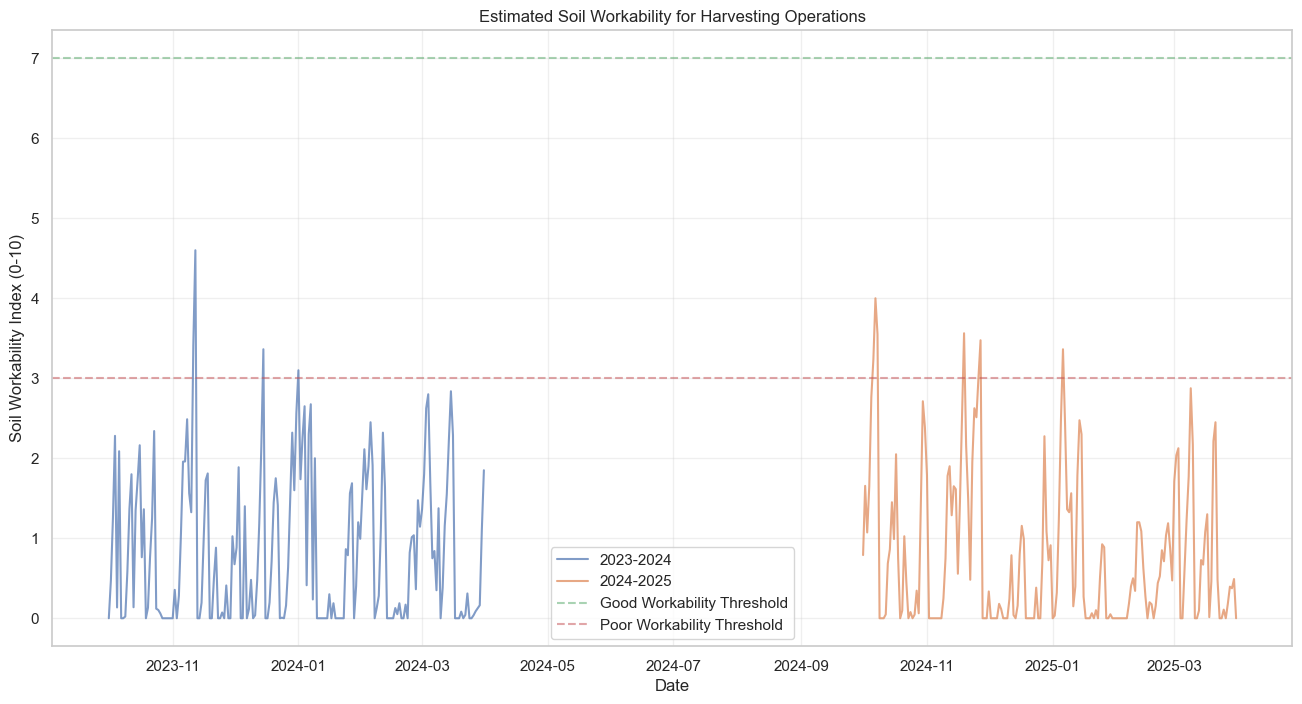

In [83]:
def calculate_soil_workability(df, precip_threshold=5, humidity_threshold=80):
    """
    Calculate a simple soil workability index based on precipitation and humidity
    Higher index = better workability (drier soil)
    """
    # Create a copy to avoid modifying the original
    df_work = df.copy()
    
    # Calculate days since last significant rainfall
    df_work['significant_rain'] = df_work['Precipitacao'] > precip_threshold
    df_work['days_since_rain'] = 0
    
    # Calculate days since last significant rainfall
    counter = 0
    for i in range(len(df_work)):
        if df_work.iloc[i]['significant_rain']:
            counter = 0
        else:
            counter += 1
        df_work.iloc[i, df_work.columns.get_loc('days_since_rain')] = counter
    
    # Calculate workability index (0-10 scale)
    # Higher values = better workability
    df_work['workability_index'] = (
        # More days since rain = better workability
        np.minimum(df_work['days_since_rain'] * 2, 10) *
        # Lower humidity = better workability
        (1 - np.minimum(df_work['Umidade_Media'] / humidity_threshold, 1)) * 
        # No rain today = better workability
        (1 - np.minimum(df_work['Precipitacao'] / precip_threshold, 1))
    )
    
    return df_work

# Calculate workability for both periods
df_2023_2024_work = calculate_soil_workability(df_2023_2024)
df_2024_2025_work = calculate_soil_workability(df_2024_2025)

# Visualize workability index over time
plt.figure(figsize=(16, 8))
plt.plot(df_2023_2024_work['Data'], df_2023_2024_work['workability_index'], 
         label='2023-2024', alpha=0.7)
plt.plot(df_2024_2025_work['Data'], df_2024_2025_work['workability_index'], 
         label='2024-2025', alpha=0.7)

plt.axhline(y=7, color='g', linestyle='--', alpha=0.5, label='Good Workability Threshold')
plt.axhline(y=3, color='r', linestyle='--', alpha=0.5, label='Poor Workability Threshold')

plt.xlabel('Date')
plt.ylabel('Soil Workability Index (0-10)')
plt.title('Estimated Soil Workability for Harvesting Operations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

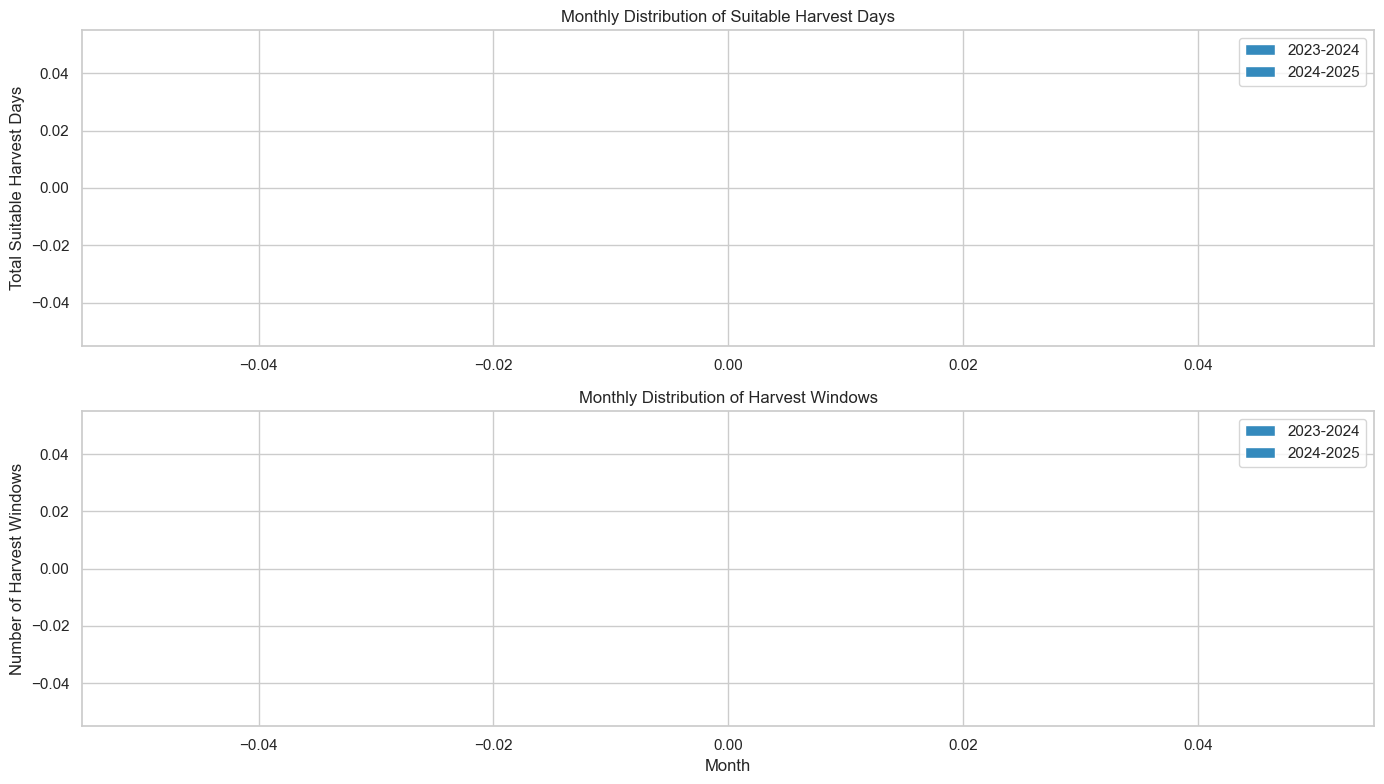

In [84]:
def identify_harvest_windows(df, min_workability=7, consecutive_days=3):
    """
    Identify potential harvest windows based on workability index
    min_workability: minimum workability index to consider suitable for harvest
    consecutive_days: minimum consecutive days needed for a harvest window
    """
    df_windows = df.copy()
    
    # Mark days suitable for harvest
    df_windows['suitable_for_harvest'] = df_windows['workability_index'] >= min_workability
    
    # Identify harvest windows (consecutive suitable days)
    df_windows['window_id'] = (df_windows['suitable_for_harvest'] != 
                              df_windows['suitable_for_harvest'].shift()).cumsum()
    
    # Count consecutive suitable days
    window_counts = df_windows.groupby(['window_id', 'suitable_for_harvest']).size().reset_index(name='consecutive_days')
    
    # Filter for suitable windows meeting the minimum consecutive days requirement
    suitable_windows = window_counts[(window_counts['suitable_for_harvest']) & 
                                    (window_counts['consecutive_days'] >= consecutive_days)]
    
    # Get date ranges for each suitable window
    if not suitable_windows.empty:
        window_dates = []
        for window_id in suitable_windows['window_id']:
            window_data = df_windows[df_windows['window_id'] == window_id]
            window_dates.append({
                'window_id': window_id,
                'start_date': window_data['Data'].min(),
                'end_date': window_data['Data'].max(),
                'duration': len(window_data),
                'month': window_data['Data'].min().month,
                'year': window_data['Data'].min().year
            })
        
        return pd.DataFrame(window_dates)
    else:
        return pd.DataFrame(columns=['window_id', 'start_date', 'end_date', 'duration', 'month', 'year'])

# Identify harvest windows for both periods
windows_2023_2024 = identify_harvest_windows(df_2023_2024_work)
windows_2024_2025 = identify_harvest_windows(df_2024_2025_work)

# Visualize harvest windows by month
plt.figure(figsize=(14, 8))

# 2023-2024 harvest windows by month
monthly_windows_2023_2024 = windows_2023_2024.groupby('month').agg(
    total_days=('duration', 'sum'),
    window_count=('window_id', 'count')
).reset_index()

# 2024-2025 harvest windows by month
monthly_windows_2024_2025 = windows_2024_2025.groupby('month').agg(
    total_days=('duration', 'sum'),
    window_count=('window_id', 'count')
).reset_index()

# Create month names for x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot total suitable harvest days by month
plt.subplot(2, 1, 1)
plt.bar([month_names[m-1] for m in monthly_windows_2023_2024['month']], 
        monthly_windows_2023_2024['total_days'], alpha=0.7, label='2023-2024')
plt.bar([month_names[m-1] for m in monthly_windows_2024_2025['month']], 
        monthly_windows_2024_2025['total_days'], alpha=0.7, label='2024-2025')
plt.ylabel('Total Suitable Harvest Days')
plt.title('Monthly Distribution of Suitable Harvest Days')
plt.legend()

# Plot number of harvest windows by month
plt.subplot(2, 1, 2)
plt.bar([month_names[m-1] for m in monthly_windows_2023_2024['month']], 
        monthly_windows_2023_2024['window_count'], alpha=0.7, label='2023-2024')
plt.bar([month_names[m-1] for m in monthly_windows_2024_2025['month']], 
        monthly_windows_2024_2025['window_count'], alpha=0.7, label='2024-2025')
plt.ylabel('Number of Harvest Windows')
plt.xlabel('Month')
plt.title('Monthly Distribution of Harvest Windows')
plt.legend()

plt.tight_layout()
plt.show()

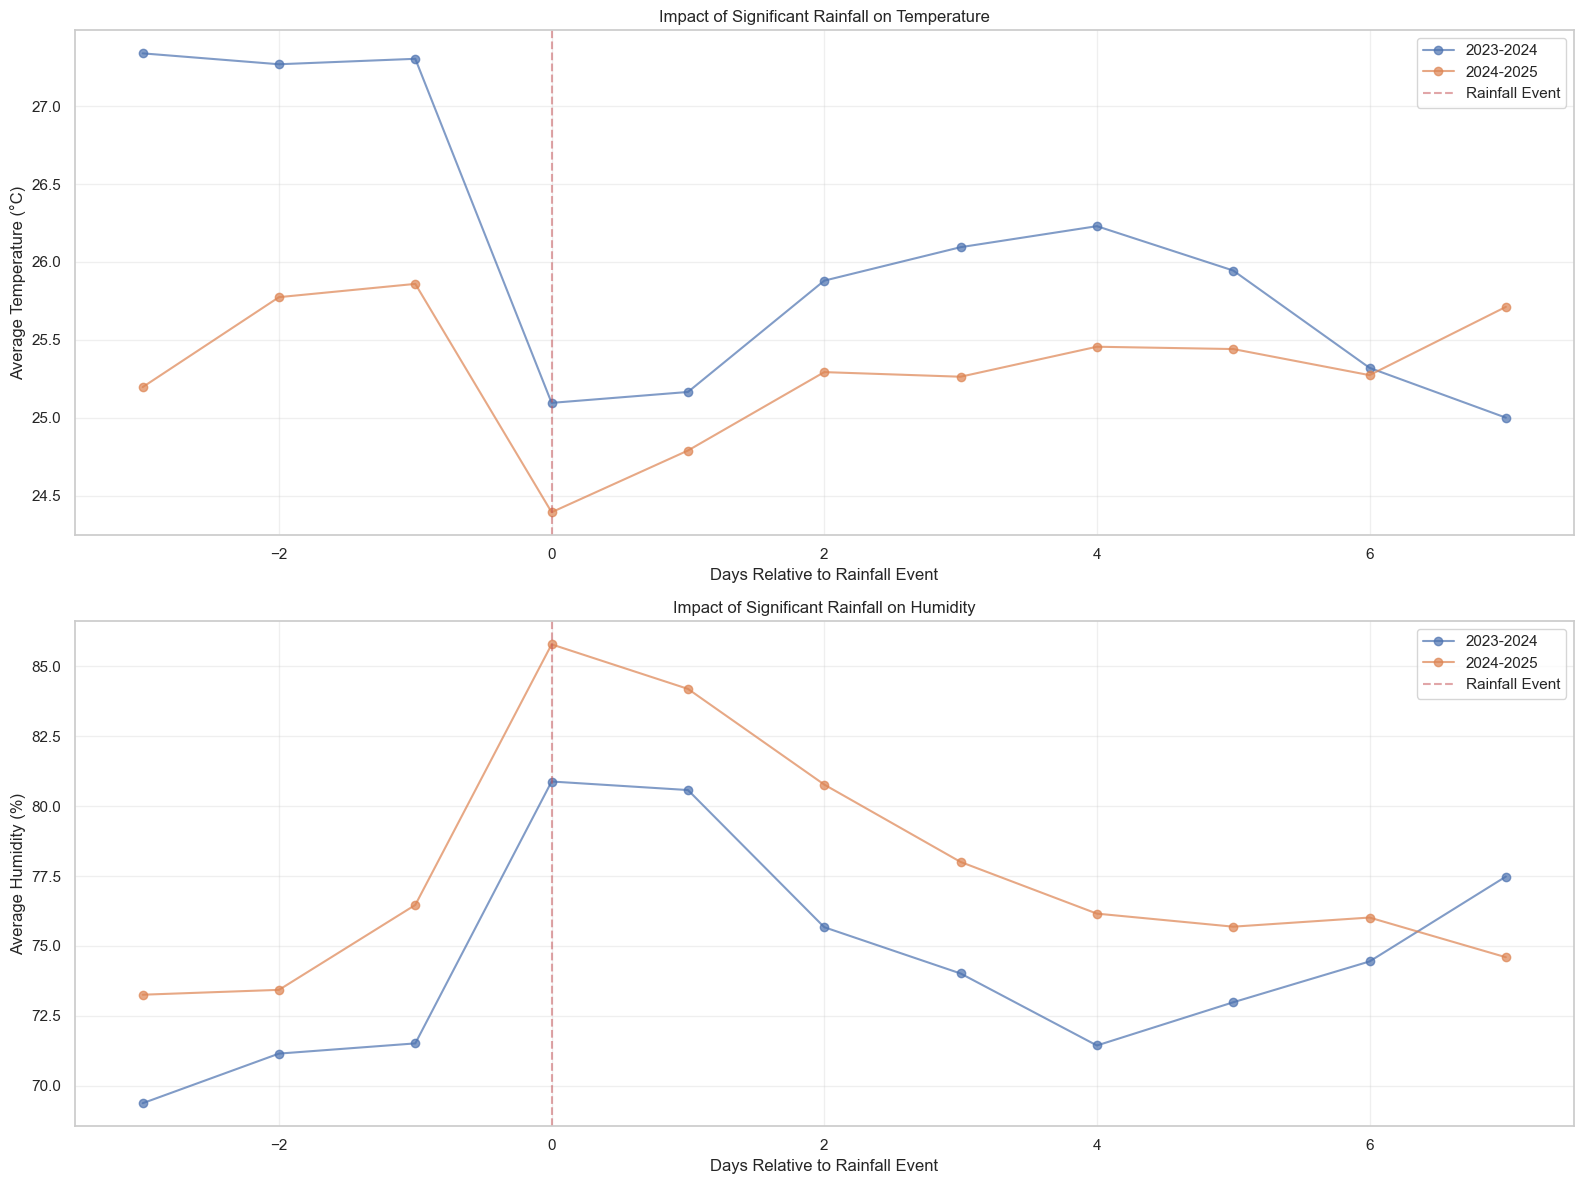

In [85]:
def analyze_rainfall_impact(df, days_before=3, days_after=7):
    """
    Analyze the impact of significant rainfall events on temperature and humidity
    days_before: days before rainfall to analyze
    days_after: days after rainfall to analyze
    """
    # Identify significant rainfall events (>10mm)
    significant_rain = df[df['Precipitacao'] > 10].copy()
    
    # For each significant rainfall event, analyze conditions before and after
    impact_data = []
    
    for idx, rain_event in significant_rain.iterrows():
        event_date = rain_event['Data']
        event_amount = rain_event['Precipitacao']
        
        # Get data for days before and after the event
        start_date = event_date - pd.Timedelta(days=days_before)
        end_date = event_date + pd.Timedelta(days=days_after)
        
        period_data = df[(df['Data'] >= start_date) & (df['Data'] <= end_date)].copy()
        
        # Calculate relative day to rainfall event
        period_data['days_from_event'] = (period_data['Data'] - event_date).dt.days
        
        # Add event identifier and rainfall amount
        period_data['event_date'] = event_date
        period_data['event_amount'] = event_amount
        
        impact_data.append(period_data)
    
    if impact_data:
        # Combine all event data
        impact_df = pd.concat(impact_data)
        
        # Group by days from event and calculate averages
        impact_summary = impact_df.groupby('days_from_event').agg({
            'Temp_Media': 'mean',
            'Umidade_Media': 'mean',
            'event_amount': 'mean'  # This will be the same for each day in the same event
        }).reset_index()
        
        return impact_summary
    else:
        return pd.DataFrame(columns=['days_from_event', 'Temperatura_Media', 'Umidade_Media', 'event_amount'])

# Analyze rainfall impact for both periods
impact_2023_2024 = analyze_rainfall_impact(df_2023_2024)
impact_2024_2025 = analyze_rainfall_impact(df_2024_2025)

# Visualize impact of rainfall on temperature and humidity
plt.figure(figsize=(16, 12))

# Plot temperature impact
plt.subplot(2, 1, 1)
plt.plot(impact_2023_2024['days_from_event'], impact_2023_2024['Temp_Media'], 
         'o-', label='2023-2024', alpha=0.7)
plt.plot(impact_2024_2025['days_from_event'], impact_2024_2025['Temp_Media'], 
         'o-', label='2024-2025', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Rainfall Event')
plt.xlabel('Days Relative to Rainfall Event')
plt.ylabel('Average Temperature (°C)')
plt.title('Impact of Significant Rainfall on Temperature')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot humidity impact
plt.subplot(2, 1, 2)
plt.plot(impact_2023_2024['days_from_event'], impact_2023_2024['Umidade_Media'], 
         'o-', label='2023-2024', alpha=0.7)
plt.plot(impact_2024_2025['days_from_event'], impact_2024_2025['Umidade_Media'], 
         'o-', label='2024-2025', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Rainfall Event')
plt.xlabel('Days Relative to Rainfall Event')
plt.ylabel('Average Humidity (%)')
plt.title('Impact of Significant Rainfall on Humidity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()